In [1]:
#import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
print(np.__version__)
import aplpy

1.16.5


In [2]:
### load constants and functions
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/(226e9))
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2) ### 
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

In [3]:
def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

In [4]:
### flux to mass for point source for simulated observation source recovery tests
### FOR JY/BEAM POINT SOURCES
### OR JY/PIX POINT SOURCES
point_flux = 0.15 ### jy/beam
#BMAJ    =   9.391762150659E-04                                                  
#BMIN    =   8.101911677255E-04
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
print(deg2_per_beam/deg2_per_pix)
#flux_integrated = point_flux*(deg2_per_pix/deg2_per_beam)
#print flux_integrated
#mass = mass_calc_submm(Wave,dustTemp,Kappa,flux_integrated,distance)

point_flux_jy_per_pix = point_flux * (deg2_per_pix/deg2_per_beam)
print(point_flux_jy_per_pix)
point_flux_jy_per_pix = 0.05
mass = mass_calc_submm(Wave,50,Kappa,point_flux_jy_per_pix,distance)

print(mass)


95.72206929962044
0.0015670367460453008
27.36849660071255


In [5]:
### NOISE CONVERSION FROM CATALOG VALUE TO SIMOBS VALUE
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
#print deg2_per_beam/deg2_per_pix
deg2_per_sr = 3282.8
noise_jy_per_sr = 4.0e6
noise_jy_per_beam = noise_jy_per_sr*(deg2_per_beam/deg2_per_sr)
noise_jy_per_pix = noise_jy_per_sr*(deg2_per_pix/deg2_per_sr)
print (noise_jy_per_pix)
print (noise_jy_per_beam)

2.3504476004378228e-05
0.002249897080942358


[130.13610413 125.80366175 121.47120311 117.13876073 112.80631835
 108.47385971 104.14141733  99.80897495  95.47651631  91.14407393
  86.81163155  82.47917291  78.14673053  73.81428815  69.48182951
  65.14938713  60.81694475  56.48448611  52.15204373  47.81960135
  43.48714271  39.15470033  34.82225795  30.48979931  26.15735693
  21.82491455  17.49245591  13.16001353   8.82757115   4.49511251
   0.16267013]


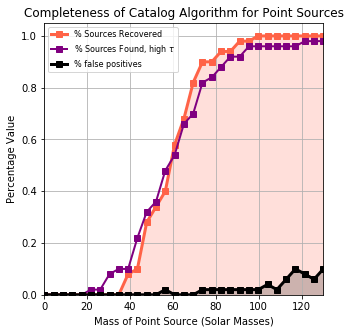

In [6]:
### Plot for mass vs percent found
### also average runs together

path = '/Users/hph/cmzoom_catalog/simobserve_acc/'

BMAJ    =   9.391762150659E-04
BMIN    =   8.101911677255E-04
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2


found_avg = np.array([1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.  ])

hightau_avg = np.array([0.98,  0.98,  0.98,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.92,  0.92,  0.88,
                        0.84,  0.82,  0.7,   0.66,  0.54,  0.48,  0.36,  0.32,  0.22,  0.1,   0.1,   0.08,
                        0.02,  0.02,  0.,    0.,    0.,    0.,    0.])

point_fluxes = np.array([0.08,        0.07733667,  0.07467333,  0.07201,     0.06934667,  0.06668333,
                         0.06402,     0.06135667,  0.05869333,  0.05603,     0.05336667,  0.05070333,
                         0.04804,     0.04537667,  0.04271333,  0.04005,     0.03738667,  0.03472333,
                         0.03206,     0.02939667,  0.02673333,  0.02407,     0.02140667,  0.01874333,
                         0.01608,     0.01341667,  0.01075333,  0.00809,     0.00542667,  0.00276333,
                         0.0001    ])
#fp_avg = np.array([1.4,  1.4,  1.4,  1.2,  0.8,  1.,   2.,   1.2,  0.8,  0.6,  0.2,  0.2,  0.2,  0.2,  0.,
#                     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
#                     0. ])
fp_avg = np.array([ 1.,   0.6, 0.8,  1.,   0.6,  0.2,  0.4,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.,
                    0.,   0.,   0.2 , 0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                    0. ])
fp_avg = fp_avg/10.
#integrated_fluxes = point_fluxes*(deg2_per_pix/deg2_per_beam)
integrated_fluxes = point_fluxes
masses = mass_calc_submm(Wave,dustTemp,Kappa,integrated_fluxes,distance)
print(masses)

plt.close()
mrfig = plt.figure(3,figsize=(5,5))
plt.rcParams.update(plt.rcParamsDefault)
ax = mrfig.gca()
ax.plot(masses, found_avg,ls='-',color='tomato',linewidth='3.0', label='% Sources Recovered',marker='s')
ax.plot(masses, hightau_avg,ls='-',color='purple',linewidth='2.0', label ='% Sources Found, high $\\tau$',marker='s')
ax.plot(masses, fp_avg,ls='-',color='k',linewidth='3.0',label='% false positives',marker='s')
plt.xlabel('Mass of Point Source (Solar Masses)')
plt.ylabel('Percentage Value')
#plt.ylabel('Percent Sources Found')
plt.title('Completeness of Catalog Algorithm for Point Sources')
ax.set_ylim(0,1.05)
ax.set_xlim(0,130.)

ax.grid()
fill = ax.fill_between(masses,found_avg, color='tomato',alpha=0.2,edgecolor='red',linewidth = '0.0')
fill = ax.fill_between(masses,fp_avg, color='k',alpha=0.2,edgecolor='k',linewidth = '0.0')
plt.legend(loc='upper left',fontsize=8)
mrfig.savefig(path+'simobs_percent_robust.pdf',format='pdf')
plt.show()


In [ ]:
def killAxis(path,targetName):
    # read the FITS data
    print( "Data loading...")
    InputMap = fits.open(path+targetName)[0]
    InputData = InputMap.data[0,0,:,:]
    print( "Data loaded!")
    print(InputMap.header)
    # beat the header into shape
    HeaderMod = InputMap.header.copy()
    HeaderMod['NAXIS'] = 2
    for i in ['1', '2', '3', '4']:
        for j in ['1', '2', '3', '4']:
            del HeaderMod['PC' + i + '_' + j]
    for i in ['3', '4']:
        for Item in ['NAXIS', 'CDELT', 'CRVAL', 'CRPIX', 'CUNIT', 'CTYPE']:
            del HeaderMod[Item + i]
    print( "Axes killed!")
            
    HDU = fits.PrimaryHDU(data=InputData,header=HeaderMod)
    HDUList = fits.HDUList([HDU])
    print( HDUList[0].header)
    HDUList.writeto(path+targetName+'_compact.fits',overwrite=True)
    print( "File written!")
    
def test(path,targetName):
    print( "Loading File...")
    testFITS = fits.open(path+targetName)
    print( "File loaded!")
    print( np.shape(testFITS[0].data))

In [ ]:
killAxis(path,'final_noregrid_image_9-27-19_0.fits')
killAxis(path,'initial_temp_image_9-27-19_0.fits')
killAxis(path,'temp_mask_9-27-19_0.fits')


In [7]:
def make_simobs_panel(path,inputfits1,inputfits2,maskfits,label):
    plt.close()
    fg_color='white'
    bg_color='black'
    contour_hdu = fits.open(path+maskfits)[0]
    data_hdu = fits.open(path+inputfits1)[0]
    #data_hdu.data = data_hdu.data[]
    fig = plt.figure(figsize=(15, 5))#,facecolor=bg_color, edgecolor=fg_color)
    print(data_hdu.data.shape)
    subplot1 = aplpy.FITSFigure(data_hdu,subplot=[0.1,0.1,0.265,0.8], slices=(2,3),
                                figure = fig, convention='calabretta') #
    vmin,vmax = -0.001,0.1
    subplot1.show_colorscale(vmin=vmin, vmax=vmax,cmap='inferno')
    subplot1.set_nan_color(bg_color)
    #subplot1.ticks.set_xspacing(0.02)
    #subplot1.ticks.set_yspacing(0.02)
    subplot1.ticks.set_color('black')
    subplot1.tick_labels.set_xformat('d.dd')
    subplot1.tick_labels.set_yformat('d.dd')
    subplot1.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'white')
    subplot1.show_contour(data=contour_hdu.data,slices=(2,3),
                         colors = 'white', levels = [0.0,], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    subplot1.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot1.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot1.ticks.show()
    subplot1.add_scalebar(length=24./3600.)
    subplot1.scalebar.set_label('1 pc')
    subplot1.scalebar.set_color('white')
    subplot1.add_colorbar()


make_simobs_panel(path,'final_noregrid_image_9-27-19_0.fits',
                  'initial_temp_image_9-27-19_0.fits',
                  'temp_mask_9-27-19_0.fits','Simulated observation')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hph/cmzoom_catalog/simobserve_acc/temp_mask_9-27-19_0.fits'

In [46]:
data_hdu = fits.open(path+'final_noregrid_image_9-27-19_0.fits')[0]
wf = wcs.WCS(data_hdu)
wf.celestial

Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SIN'  'GLAT-SIN'  
CRVAL : 1.61  -0.0045  
CRPIX : 101.0  101.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  
NAXIS : 200  200  1  1

In [4]:
### aplpy figures for simobs frames
def make_simobs_panel(path,inputfits1,inputfits2,maskfits,label):
    plt.close()
    fg_color='white'
    bg_color='black'
    contour_hdu = fits.open(path+maskfits)[0]
    data_hdu = fits.open(path+inputfits1)[0]
    fits.open(path+inputfits2)[0]

    #data_hdu.data = data_hdu.data[]
    fig = plt.figure(figsize=(11.2, 4.8))#,facecolor=bg_color, edgecolor=fg_color)
    print(data_hdu.data.shape)
    subplot1 = aplpy.FITSFigure(data_hdu,subplot=[0.05,0.05,0.38,0.9], 
                                figure = fig, convention='calabretta') #
    vmin,vmax = -0.001,0.1
    subplot1.show_colorscale(vmin=vmin, vmax=vmax,cmap='inferno')
    #subplot.frame.set_color(fg_color)
    subplot1.set_nan_color(bg_color)
    #subplot1.ticks.set_xspacing(0.02)
    #subplot1.ticks.set_yspacing(0.02)
    subplot1.ticks.set_color('black')
    subplot1.tick_labels.set_xformat('d.dd')
    subplot1.tick_labels.set_yformat('d.dd')
    #subplot.ticks.set_color(fg_color)
    #subplot.recenter(xcenter, ycenter, width = 50. / 3600., height = 50. / 3600.)
    subplot1.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'white')
    #subplot.show_markers(xcenter, ycenter, marker = '+', facecolor = 'red', edgecolor = 'red', s = 1000)
    subplot1.show_contour(data=contour_hdu.data,
                         colors = 'white', levels = [0.0,], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    subplot1.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot1.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot1.ticks.show()
    subplot1.add_scalebar(length=24./3600.)
    subplot1.scalebar.set_label('1 pc')
    subplot1.scalebar.set_color('white')
    subplot1.add_colorbar()
    subplot1.add_beam()
    plt.text(0.47, 0.9, 'Jy/beam', fontsize=12,color='k', transform=plt.gcf().transFigure)
    #subplot1.add_label(0.5, 0.95, 'Jy/beam', relative=True,color='k')
    
    init_hdu=fits.open(path+inputfits2)[0]
    subplot2 = aplpy.FITSFigure(init_hdu,subplot=[0.55,0.05,0.38,0.9],
                                figure = fig, convention='calabretta') # slices = (2,3),
    

    initial_wcs = wcs.WCS(init_hdu.header)
    data_wcs = wcs.WCS(data_hdu.header)
    init_cond = np.where(initial_data!=0)
    
    wcs_init = initial_wcs.wcs_pix2world(init_cond[0],init_cond[1],1)
    transformed_pix = data_wcs.wcs_world2pix(wcs_init[0],wcs_init[1],1)
    
    vmin,vmax = -0.001,1000.
    subplot2.show_colorscale(vmin=vmin, vmax=vmax,cmap='inferno')
    subplot2.show_contour(data=contour_hdu.data,
                         colors = 'white', levels = [0.0,], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    #subplot.frame.set_color(fg_color)
    #subplot2.set_nan_color(bg_color)
    #subplot2.ticks.set_xspacing(0.02)
    #subplot2.ticks.set_yspacing(0.02)
    subplot2.ticks.set_color('black')
    subplot2.tick_labels.set_xformat('d.dd')
    subplot2.tick_labels.set_yformat('d.dd')
    subplot2.add_label(0.48, 0.95, 'Random Point Souce Map', relative = True, weight = 'bold', 
                       size = 10, color = 'k')
    plt.scatter(transformed_pix[1]-9,transformed_pix[0]+9,color='limegreen',marker='x')
    #plt.scatter(init_cond[1],init_cond[0],color='red',marker='x')

    #plt.scatter(transformed_pix[1],transformed_pix[0],color='k',marker='o')
    subplot2.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot2.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot2.ticks.show()
    subplot2.add_scalebar(length=24./3600.)
    subplot2.scalebar.set_label('1 pc')
    subplot2.scalebar.set_color('white')
    #subplot2.add_colorbar()
    
    #plt.plot()
    #fig.tight_layout()
    fig.savefig(path+'simobs_example.pdf',format='pdf')
    #plt.show()
    return init_cond

init_cond = make_simobs_panel(path,'final_noregrid_image_9-27-19_0.fits',
                  'initial_temp_image_9-27-19_0.fits',
                  'temp_mask_9-27-19_0.fits','Simulated observation')



NameError: name 'path' is not defined

In [127]:
init_cond

(array([ 54,  64,  68,  80,  92, 104, 113, 115, 120, 137]),
 array([135, 120, 113,  86, 116,  66,  93,  54, 116, 124]))

INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)


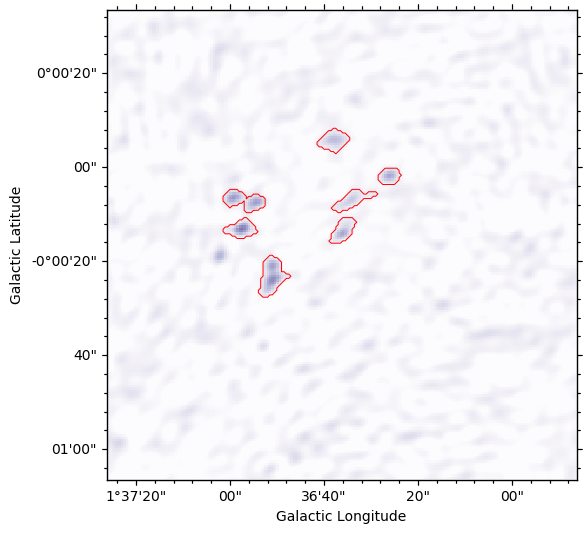

In [15]:

final_hdu = fits.open(path+'final_noregrid_image_8-20-1915.fits')[0]
subplot1 = aplpy.FITSFigure(final_hdu, convention='calabretta',figsize=(5,5))
vmin,vmax = -0.001,0.05
subplot1.show_colorscale(vmin=vmin, vmax=vmax,cmap='Purples')
contour_hdu = fits.open(path+'temp_mask_8-20-1915.fits')[0]
subplot1.show_contour(data=contour_hdu.data,
                      colors = 'red', levels = [0.0,], linewidths = 0.7,
                      convention = 'calabretta', zorder = 10, linestyle = 'solid')
plt.tight_layout()
plt.savefig('/Users/hph/cmzoom_catalog/catalog_acc/single_simobs_example.pdf',format='pdf',bbox_inches='tight')

In [10]:
path

'/Users/hph/cmzoom_catalog/simobserve_acc/'

In [ ]:
mask_hdu=fits.open(path+'temp_mask_9-27-19_0.fits')
final_hdu=fits.open(path+'final_noregrid_image_9-27-19_0.fits')
print(wcs.WCS(final_hdu[0]))
#wcs.WCS(final_hdu[0])
#wcs.WCS(mask_hdu[0])
#print(mask_hdu[0].header)

In [52]:
def fix_bad_axes(path,filename):
    initial_hdu = fits.open(path+filename)[0]
    print("initial # axes, data shape: ",initial_hdu.header['NAXIS'],initial_hdu.data.shape)
    if initial_hdu.data.shape==(1, 1, 200, 200):
        initial_hdu.data = initial_hdu.data[0,0,:,:]
    for keyval in ['CRVAL3','CRVAL4','CTYPE3','CTYPE4','CDELT3','CDELT4','CUNIT3','CUNIT4','CRPIX3','CRPIX4',
                   'PC03_01','PC03_02','PC03_03','PC03_04','PC04_01','PC04_02',
                   'PC04_03','PC04_04','PC01_03','PC01_04','PC02_03','PC02_04',
                   'PC3_1','PC3_2','PC3_3','PC3_4','PC4_1','PC4_2',
                   'PC4_3','PC4_4','PC1_3','PC1_4','PC2_3','PC2_4']:
        if keyval in list(initial_hdu.header.keys()):
            print('Eliminating '+keyval+'...')
            initial_hdu.header.remove(keyval)
    initial_hdu.header['NAXIS']=2
    fits.writeto(path+filename,data=initial_hdu.data,header=initial_hdu.header,overwrite=True)
    print("initial # axes, data shape: ",initial_hdu.header['NAXIS'],initial_data.shape)
    print(path+filename)

fix_bad_axes(path,'initial_temp_image_9-27-19_0.fits')
fix_bad_axes(path,'final_noregrid_image_9-27-19_0.fits')
fix_bad_axes(path,'temp_mask_9-27-19_0.fits')

initial # axes, data shape:  2 (200, 200)
initial # axes, data shape:  2 (200, 200)
/Users/hph/cmzoom_catalog/simobserve_kernel/initial_temp_image_9-27-19_0.fits
initial # axes, data shape:  4 (1, 1, 200, 200)
initial # axes, data shape:  2 (200, 200)
/Users/hph/cmzoom_catalog/simobserve_kernel/final_noregrid_image_9-27-19_0.fits
initial # axes, data shape:  2 (200, 200)
Eliminating CRVAL3...
Eliminating CRVAL4...
Eliminating CTYPE3...
Eliminating CTYPE4...
Eliminating CDELT3...
Eliminating CDELT4...
Eliminating CUNIT3...
Eliminating CUNIT4...
Eliminating CRPIX3...
Eliminating CRPIX4...
Eliminating PC3_1...
Eliminating PC3_2...
Eliminating PC3_3...
Eliminating PC3_4...
Eliminating PC4_1...
Eliminating PC4_2...
Eliminating PC4_3...
Eliminating PC4_4...
Eliminating PC1_3...
Eliminating PC1_4...
Eliminating PC2_3...
Eliminating PC2_4...
initial # axes, data shape:  2 (200, 200)
/Users/hph/cmzoom_catalog/simobserve_kernel/temp_mask_9-27-19_0.fits


In [51]:
initial_hdu = fits.open(path+'initial_temp_image_9-27-19_0.fits')[0]
final_hdu = fits.open(path+'final_noregrid_image_9-27-19_0.fits')[0]

def fix_bad_axes(path,filename):
    initial_hdu = fits.open(path+filename)[0]
    initial_data = initial_hdu.data[0,0,:,:]
    initial_hdu.header.remove('CRVAL3')
    initial_hdu.header.remove('CRVAL4')
    initial_hdu.header.remove('CTYPE3')
    initial_hdu.header.remove('CTYPE4')
    initial_hdu.header.remove('CDELT3')
    initial_hdu.header.remove('CDELT4')
    initial_hdu.header.remove('CUNIT3')
    initial_hdu.header.remove('CUNIT4')
    initial_hdu.header.remove('CRPIX3')
    initial_hdu.header.remove('CRPIX4')
    initial_hdu.header.remove('PC03_01')
    initial_hdu.header.remove('PC03_02')
    initial_hdu.header.remove('PC03_03')
    initial_hdu.header.remove('PC03_04')
    initial_hdu.header.remove('PC04_01')
    initial_hdu.header.remove('PC04_02')
    initial_hdu.header.remove('PC04_03')
    initial_hdu.header.remove('PC04_04')
    initial_hdu.header.remove('PC01_03')
    initial_hdu.header.remove('PC01_04')
    initial_hdu.header.remove('PC02_03')
    initial_hdu.header.remove('PC02_04')
    initial_hdu.writeto(path+filename,overwrite=True)
    

initial_data = initial_hdu.data
initial_hdu.header.remove('CRVAL3')
initial_hdu.header.remove('CRVAL4')
initial_hdu.header.remove('CTYPE3')
initial_hdu.header.remove('CTYPE4')
initial_hdu.header.remove('CDELT3')
initial_hdu.header.remove('CDELT4')
initial_hdu.header.remove('CUNIT3')
initial_hdu.header.remove('CUNIT4')
initial_hdu.header.remove('CRPIX3')
initial_hdu.header.remove('CRPIX4')
initial_hdu.header.remove('PC03_01')
initial_hdu.header.remove('PC03_02')
initial_hdu.header.remove('PC03_03')
initial_hdu.header.remove('PC03_04')
initial_hdu.header.remove('PC04_01')
initial_hdu.header.remove('PC04_02')
initial_hdu.header.remove('PC04_03')
initial_hdu.header.remove('PC04_04')
initial_hdu.header.remove('PC01_03')
initial_hdu.header.remove('PC01_04')
initial_hdu.header.remove('PC02_03')
initial_hdu.header.remove('PC02_04')

final_hdu.header.remove('CRVAL3')
final_hdu.header.remove('CRVAL4')
final_hdu.header.remove('CTYPE3')
final_hdu.header.remove('CTYPE4')
final_hdu.header.remove('CDELT3')
final_hdu.header.remove('CDELT4')
final_hdu.header.remove('CUNIT3')
final_hdu.header.remove('CUNIT4')
final_hdu.header.remove('CRPIX3')
final_hdu.header.remove('CRPIX4')
final_hdu.header.remove('PC3_1')
final_hdu.header.remove('PC3_2')
final_hdu.header.remove('PC3_3')
final_hdu.header.remove('PC3_4')
final_hdu.header.remove('PC4_1')
final_hdu.header.remove('PC4_2')
final_hdu.header.remove('PC4_3')
final_hdu.header.remove('PC4_4')
final_hdu.header.remove('PC1_3')
final_hdu.header.remove('PC1_4')
final_hdu.header.remove('PC2_3')
final_hdu.header.remove('PC2_4')
final_hdu.header.remove('NAXIS3')
final_hdu.header.remove('NAXIS4')
final_hdu.header['NAXIS']=2


final_wcs = wcs.WCS(final_hdu)
final_wcs = final_wcs.celestial

print(final_hdu.header)
initial_hdu.writeto(path+'initial_temp_image_9-27-19_0.fits',overwrite=True)
final_hdu.writeto(path+'final_noregrid_image_9-27-19_0.fits',overwrite=True)

#print np.where(initial_data!=0)
#initial_wcs = wcs.WCS(initial_hdu.header)
#initial_wcs
#init_cond = np.where(initial_data!=0)
#print initial_wcs
#wcs_init = initial_wcs.wcs_pix2world(init_cond[0],init_cond[1],1)
#print wcs_init
#transformed_pix = initial_wcs.wcs_world2pix(wcs_init[0],wcs_init[1],1)

KeyError: "Keyword 'CRVAL3' not found."

In [ ]:
path = '/Users/hph/cmzoom_catalog/simobserve_kernel/'
make_simobs_panel(path,'initial_temp_image_9-27-19_0.fits','temp_mask_9-27-19_0.fits','Simulated Image')
plt.show()

In [ ]:
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
print (deg2_per_beam/deg2_per_pix)/2

In [ ]:
#### Make IMF figure
lim_vals = np.linspace(10,100,20)
num_massive_avg = np.zeros(len(lim_vals))
for j in range(len(lim_vals)):
    has_massive = np.zeros(1000)
    for i in range(1000):
        if len(np.where(imf.make_cluster(lim_vals[j])>10)[0])>0: has_massive[i]=1
    num_massive_avg[j]=has_massive.sum()/1000

In [ ]:
cluster = imf.make_cluster(75)
print(cluster.max())
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))
###
ax.set_ylabel('Number of Stars')
ax.set_xlabel('Mass (M$_\odot$)')

mmin, mmax = min(cluster), max(cluster)
cluster_logbins = np.logspace(np.log10(mmin), np.log10(mmax),20)
h1,l1,p1 = ax.hist(cluster,
                   cluster_logbins, color='cornflowerblue',alpha=0.7, log=True)
h1,l1,p1 = ax.hist(cluster,
                   cluster_logbins, color='k',alpha=1.0,histtype='step', log=True)
ax.plot([10,10],[0,100],color='red',ls='--')
ax.set_xscale("log")
ax.set_ylim(0.9,50)
ax.set_xlim(0,100)
plt.show()

In [ ]:
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))
ax.scatter(lim_vals,num_massive_avg,marker='o',color='k')
ax.set_xlabel('Mass (M$_\odot$)')
ax.set_ylabel('Probability of Containing >0 Massive Stars (M>10M$_\odot$)')
ax.grid()
plt.savefig(path+'imf_completeness.pdf')
plt.show()

In [ ]:
print lim_vals
print num_massive_avg

In [44]:
### Plot for mass vs percent found
path='/Users/hph/cmzoom_catalog/catalog_5-28-19/'
### also average runs together
BMAJ    =   9.391762150659E-04
BMIN    =   8.101911677255E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2

found_avg = np.array([1., 1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.  ])

complete_found = [1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
                  0.9,  0.9,  0.9,  0.9,  0.9,  0.8,  0.8,  0.4,  0.4,  0.3,  0.1,  0.1,  0.2,  0.1,  0., 0.]

complete_found2 = [ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
  1.,   1.,   1.,   1.,   0.8,  0.8,  0.5,  0.3,  0.2,  0.2,  0.1,  0.1,  0.1,  0.,   0.,
  0. ]

hightau_avg = np.array([0.98, 0.98,  0.98,  0.98,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.92,  0.92,  0.88,
                        0.84,  0.82,  0.7,   0.66,  0.54,  0.48,  0.36,  0.32,  0.22,  0.1,   0.1,   0.08,
                        0.02,  0.02,  0.,    0.,    0.,    0.,    0.])

point_fluxes = np.array([0.5, 0.08,        0.07733667,  0.07467333,  0.07201,     0.06934667,  0.06668333,
                         0.06402,     0.06135667,  0.05869333,  0.05603,     0.05336667,  0.05070333,
                         0.04804,     0.04537667,  0.04271333,  0.04005,     0.03738667,  0.03472333,
                         0.03206,     0.02939667,  0.02673333,  0.02407,     0.02140667,  0.01874333,
                         0.01608,     0.01341667,  0.01075333,  0.00809,     0.00542667,  0.00276333,
                         0.0001    ])# added high flux point for ease of plotting, temporary
#fp_avg = np.array([1.4,  1.4,  1.4,  1.2,  0.8,  1.,   2.,   1.2,  0.8,  0.6,  0.2,  0.2,  0.2,  0.2,  0.,
#                     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
#                     0. ])
fp_avg = np.array([1, 1.,   0.6, 0.8,  1.,   0.6,  0.2,  0.4,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.,
                    0.,   0.,   0.2 , 0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                    0. ])
fp_avg = fp_avg/10.
#integrated_fluxes = point_fluxes*(deg2_per_pix/deg2_per_beam)

select_found = found_avg#complete_found2
select_fp_avg = fp_avg

integrated_fluxes = point_fluxes
masses = mass_calc_submm(Wave,dustTemp,Kappa,integrated_fluxes,distance)
masses_highT = mass_calc_submm(Wave,50.,Kappa,integrated_fluxes,distance)
print(masses.shape)
print(masses_highT.shape)

plt.close()
mrfig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,9))
ax.plot(masses, select_found,ls='-',color='cornflowerblue',linewidth=3.0, 
        label='% Sources Recovered, T$_d$ = 20K')
ax.set_xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Found')
ax.set_title('Completeness of Catalog Algorithm for Point Sources')
ax.set_ylim(0,1.05)
ax.set_xlim(0,130.)
ax.plot(masses, hightau_avg,ls='-',color='purple',linewidth=2.0, label ='% Sources Found, high Tau0, T$_d$=20K' )

ax.grid()
fill = ax.fill_between(masses,select_found, color='cornflowerblue',alpha=0.2,edgecolor='red',linewidth = '0.0')
fill = ax.fill_between(masses,select_fp_avg, color='k',alpha=0.6,edgecolor='k',linewidth = '0.0',
                       label = 'Percent of False Positive Detections (T$_d$=20K)')

ax.plot(masses_highT, select_found,ls='-',color='tomato',linewidth=3.0, 
        label='% Sources Recovered, T$_d$ = 50K')
plt.xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Recovered')
plt.title('Completeness of Catalog Algorithm for Point Sources')
ax.grid()
fill = ax.fill_between(masses_highT,select_found, color='tomato',alpha=0.2,edgecolor='red',linewidth = '0.0')
#fill = ax.fill_between(masses_highT,select_fp_avg, color='k',alpha=0.2,edgecolor='k',linewidth = '0.0')
plt.legend(loc='center right',fontsize=9)
ax.grid()
#####################################################################
#plt.savefig(path+'simobs_percent_5-28-19.pdf')
plt.show()

(32,)
(32,)


TypeError: Cannot cast array data from dtype('<U3') to dtype('float64') according to the rule 'safe'

<Figure size 900x900 with 1 Axes>

(30,)
(30,)


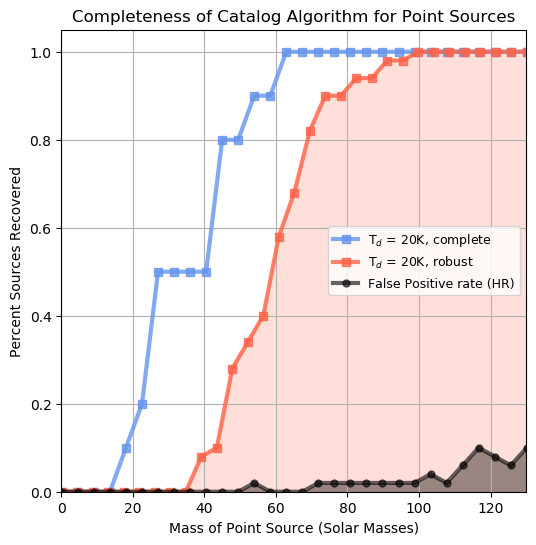

In [43]:
### Plot for mass vs percent found
path='/Users/hph/cmzoom_catalog/catalog_acc/'
plt.close()
### also average runs together
BMAJ    =   9.391762150659E-04
BMIN    =   8.101911677255E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2

desiredPeakValue = .08#4.*10**7
max_init_Peak = round(desiredPeakValue,3)
desired_Min_Peak = 0.0001
min_Peak = round(desired_Min_Peak,4)
step_array = np.linspace(max_init_Peak, min_Peak,30)

found_avg = np.array([1., 1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.  ])

complete_found = [1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
                  0.9,  0.9,  0.9,  0.9,  0.9,  0.8,  0.8,  0.4,  0.4,  0.3,  0.1,  0.1,  0.2,  0.1,  0., 0.]

complete_found2 = [ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
  1.,   1.,   1.,   1.,   0.8,  0.8,  0.5,  0.3,  0.2,  0.2,  0.1,  0.1,  0.1,  0.,   0.,
  0. ]

complete_found3 = np.array([ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   0.9,  0.9,  1.,   0.9,  0.8,
  0.7,  0.3,  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0. ])

complete_found4 = np.array([ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   0.9,
  0.7,  0.6,  0.5,  0.5,  0.4,  0.4,  0.4,  0.3,  0.3,  0.2,  0.,   0.,   0.,   0.,   0. ])

complete_found5 = np.array([1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
                            1.,   0.9,  0.9,  0.8,  0.8,  0.5,  0.5, 0.5,  0.5,  0.2,  0.1,  0.,   0.,   0.,   0. ])

hightau_avg = np.array([0.98, 0.98,  0.98,  0.98,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.92,  0.92,  0.88,
                        0.84,  0.82,  0.7,   0.66,  0.54,  0.48,  0.36,  0.32,  0.22,  0.1,   0.1,   0.08,
                        0.02,  0.02,  0.,    0.,    0.,    0.,    0.])

point_fluxes = np.array([0.5, 0.08,        0.07733667,  0.07467333,  0.07201,     0.06934667,  0.06668333,
                         0.06402,     0.06135667,  0.05869333,  0.05603,     0.05336667,  0.05070333,
                         0.04804,     0.04537667,  0.04271333,  0.04005,     0.03738667,  0.03472333,
                         0.03206,     0.02939667,  0.02673333,  0.02407,     0.02140667,  0.01874333,
                         0.01608,     0.01341667,  0.01075333,  0.00809,     0.00542667,  0.00276333,
                         0.0001    ])# added high flux point for ease of plotting, temporary
point_fluxes2 = np.array([0.06,        0.05800333,  0.05600667,  0.05401,     0.05201333,  0.05001667,
                          0.04802,     0.04602333,  0.04402667,  0.04203,     0.04003333,  0.03803667,
                          0.03604,     0.03404333,  0.03204667,  0.03005,     0.02805333])

#fp_avg = np.array([1.4,  1.4,  1.4,  1.2,  0.8,  1.,   2.,   1.2,  0.8,  0.6,  0.2,  0.2,  0.2,  0.2,  0.,
#                     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
#                     0. ])
fp_avg = np.array([1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                   0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
fp_avg = np.array([ 1.,   0.6, 0.8,  1.,   0.6,  0.2,  0.4,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.,
                    0.,   0.,   0.2 , 0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0. ])
fp_avg = fp_avg/10.

#integrated_fluxes = point_fluxes*(deg2_per_pix/deg2_per_beam)

select_found = complete_found5
select_fp_avg = fp_avg
hr_found = found_avg
hr_masses = mass_calc_submm(Wave,dustTemp,Kappa,point_fluxes,distance)

integrated_fluxes = step_array
masses = mass_calc_submm(Wave,dustTemp,Kappa,integrated_fluxes,distance)
masses_highT = mass_calc_submm(Wave,50.,Kappa,integrated_fluxes,distance)
print(masses.shape)
print(masses_highT.shape)

plt.close()
mrfig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
ax.plot(masses, select_found,ls='-',color='cornflowerblue',linewidth=3.0, marker='s',alpha=0.8,
        label='T$_d$ = 20K, complete')
ax.plot(hr_masses, hr_found,ls='-',color='tomato',linewidth=3.0, marker='s',alpha=0.8,
        label='T$_d$ = 20K, robust')
fill = ax.fill_between(hr_masses,hr_found, color='tomato',alpha=0.2,edgecolor='k')

ax.set_xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Found')
ax.set_title('Completeness of Catalog Algorithm for Point Sources')
ax.set_ylim(0,1.05)
ax.set_xlim(0,130.)
#ax.plot(masses, hightau_avg,ls='-',color='purple',linewidth=2.0, label ='% Sources Found, high Tau0, T$_d$=20K' )

ax.grid()
#fill = ax.fill_between(masses,select_found, color='cornflowerblue',alpha=0.2,edgecolor='red',linewidth = '0.0')
fill = ax.fill_between(masses,select_fp_avg, color='k',alpha=0.4,edgecolor='k',linewidth = '0.0')
ax.plot(masses,select_fp_avg,alpha=0.6,color='k',linewidth = '3.0', marker='.',markersize=10,
                       label = 'False Positive rate (HR)')

#ax.plot(masses_highT, select_found,ls='-',color='tomato',linewidth=3.0, 
#        label='% Sources Recovered, T$_d$ = 50K')
plt.xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Recovered')
plt.title('Completeness of Catalog Algorithm for Point Sources')
ax.grid()
#fill = ax.fill_between(masses_highT,select_found, color='tomato',alpha=0.2,edgecolor='red',linewidth = '0.0')
#fill = ax.fill_between(masses_highT,select_fp_avg, color='k',alpha=0.2,edgecolor='k',linewidth = '0.0')
plt.legend(loc='center right',fontsize=9)
ax.grid()
#####################################################################
plt.savefig(path+'simobs_percent_both.pdf')
plt.show()



In [51]:
catalog = Table.read('/Users/hph/cmzoom_catalog/catalog_acc/catalog_acc.fits')
massmin = min(catalog['mass'])
massmax = max(catalog['mass'])
massbins = np.logspace(np.log10(massmin), np.log10(massmax),15)

In [1]:
print(massbins)

NameError: name 'massbins' is not defined

In [52]:
#### Make IMF figure
lim_vals = massbins
percent_has_massive_avg = np.zeros(len(lim_vals))
num_massive_avg = np.zeros(len(lim_vals))
for j in range(len(lim_vals)):
    has_massive = np.zeros(1000)
    num_massive = np.zeros(1000)
    for i in range(1000):
        num_massive[i]=len(np.where(imf.make_cluster(lim_vals[j])>8)[0])
        if num_massive[i]>0: has_massive[i]=1
    percent_has_massive_avg[j]=has_massive.sum()/1000
    num_massive_avg[j] = num_massive.sum()/1000

Total cluster mass is 4.34339 (limit was 4.07545)
Total cluster mass is 2.71971 (limit was 4.07545)
Total cluster mass is 4.03853 (limit was 4.07545)
Total cluster mass is 4.10693 (limit was 4.07545)
Total cluster mass is 4.0854 (limit was 4.07545)
Total cluster mass is 4.30212 (limit was 4.07545)
Total cluster mass is 4.92713 (limit was 4.07545)
Total cluster mass is 4.20792 (limit was 4.07545)
Total cluster mass is 3.63096 (limit was 4.07545)
Total cluster mass is 3.87734 (limit was 4.07545)
Total cluster mass is 0.752597 (limit was 4.07545)
Total cluster mass is 4.05998 (limit was 4.07545)
Total cluster mass is 1.39422 (limit was 4.07545)
Total cluster mass is 3.62581 (limit was 4.07545)
Total cluster mass is 3.81285 (limit was 4.07545)
Total cluster mass is 4.6031 (limit was 4.07545)
Total cluster mass is 4.12155 (limit was 4.07545)
Total cluster mass is 4.03335 (limit was 4.07545)
Total cluster mass is 4.05514 (limit was 4.07545)
Total cluster mass is 5.67247 (limit was 4.07545)
T

Total cluster mass is 4.10592 (limit was 4.07545)
Total cluster mass is 4.10531 (limit was 4.07545)
Total cluster mass is 4.21262 (limit was 4.07545)
Total cluster mass is 4.09183 (limit was 4.07545)
Total cluster mass is 4.06216 (limit was 4.07545)
Total cluster mass is 4.81423 (limit was 4.07545)
Total cluster mass is 4.08047 (limit was 4.07545)
Total cluster mass is 4.08059 (limit was 4.07545)
Total cluster mass is 4.08434 (limit was 4.07545)
Total cluster mass is 1.75299 (limit was 4.07545)
Total cluster mass is 3.47054 (limit was 4.07545)
Total cluster mass is 4.6447 (limit was 4.07545)
Total cluster mass is 4.16659 (limit was 4.07545)
Total cluster mass is 5.08654 (limit was 4.07545)
Total cluster mass is 3.78798 (limit was 4.07545)
Total cluster mass is 4.76369 (limit was 4.07545)
Total cluster mass is 4.42871 (limit was 4.07545)
Total cluster mass is 4.10033 (limit was 4.07545)
Total cluster mass is 3.98707 (limit was 4.07545)
Total cluster mass is 3.94569 (limit was 4.07545)
T

Total cluster mass is 3.99632 (limit was 4.07545)
Total cluster mass is 5.81208 (limit was 4.07545)
Total cluster mass is 3.82233 (limit was 4.07545)
Total cluster mass is 4.16036 (limit was 4.07545)
Total cluster mass is 3.55087 (limit was 4.07545)
Total cluster mass is 1.511 (limit was 4.07545)
Total cluster mass is 4.3463 (limit was 4.07545)
Total cluster mass is 2.98026 (limit was 4.07545)
Total cluster mass is 4.91434 (limit was 4.07545)
Total cluster mass is 4.14065 (limit was 4.07545)
Total cluster mass is 4.61977 (limit was 4.07545)
Total cluster mass is 4.36762 (limit was 4.07545)
Total cluster mass is 5.77875 (limit was 4.07545)
Total cluster mass is 2.85573 (limit was 4.07545)
Total cluster mass is 4.46227 (limit was 4.07545)
Total cluster mass is 4.51204 (limit was 4.07545)
Total cluster mass is 4.40086 (limit was 4.07545)
Total cluster mass is 4.00281 (limit was 4.07545)
Total cluster mass is 3.75727 (limit was 4.07545)
Total cluster mass is 3.55909 (limit was 4.07545)
Tot

Total cluster mass is 3.97818 (limit was 4.07545)
Total cluster mass is 4.256 (limit was 4.07545)
Total cluster mass is 4.02418 (limit was 4.07545)
Total cluster mass is 3.83066 (limit was 4.07545)
Total cluster mass is 3.64795 (limit was 4.07545)
Total cluster mass is 3.44543 (limit was 4.07545)
Total cluster mass is 4.31388 (limit was 4.07545)
Total cluster mass is 3.35932 (limit was 4.07545)
Total cluster mass is 3.92348 (limit was 4.07545)
Total cluster mass is 4.13206 (limit was 4.07545)
Total cluster mass is 4.2615 (limit was 4.07545)
Total cluster mass is 5.15218 (limit was 4.07545)
Total cluster mass is 4.11153 (limit was 4.07545)
Total cluster mass is 4.05341 (limit was 4.07545)
Total cluster mass is 4.03069 (limit was 4.07545)
Total cluster mass is 4.09431 (limit was 4.07545)
Total cluster mass is 4.07531 (limit was 4.07545)
Total cluster mass is 5.72087 (limit was 4.07545)
Total cluster mass is 2.09843 (limit was 4.07545)
Total cluster mass is 1.74929 (limit was 4.07545)
Tot

Total cluster mass is 3.09001 (limit was 4.07545)
Total cluster mass is 4.49208 (limit was 4.07545)
Total cluster mass is 4.08915 (limit was 4.07545)
Total cluster mass is 3.97954 (limit was 4.07545)
Total cluster mass is 3.7697 (limit was 4.07545)
Total cluster mass is 3.68749 (limit was 4.07545)
Total cluster mass is 4.16774 (limit was 4.07545)
Total cluster mass is 4.11689 (limit was 4.07545)
Total cluster mass is 4.63728 (limit was 4.07545)
Total cluster mass is 2.04069 (limit was 4.07545)
Total cluster mass is 3.84846 (limit was 4.07545)
Total cluster mass is 4.03851 (limit was 4.07545)
Total cluster mass is 4.078 (limit was 4.07545)
Total cluster mass is 5.13485 (limit was 4.07545)
Total cluster mass is 3.90914 (limit was 4.07545)
Total cluster mass is 4.43947 (limit was 4.07545)
Total cluster mass is 4.21316 (limit was 4.07545)
Total cluster mass is 0.49257 (limit was 4.07545)
Total cluster mass is 4.06053 (limit was 4.07545)
Total cluster mass is 4.18371 (limit was 4.07545)
Tot

Total cluster mass is 9.96378 (limit was 8.23008)
Total cluster mass is 8.24472 (limit was 8.23008)
Total cluster mass is 2.43814 (limit was 8.23008)
Total cluster mass is 8.96233 (limit was 8.23008)
Total cluster mass is 8.01839 (limit was 8.23008)
Total cluster mass is 8.28962 (limit was 8.23008)
Total cluster mass is 10.9361 (limit was 8.23008)
Total cluster mass is 7.95899 (limit was 8.23008)
Total cluster mass is 8.38783 (limit was 8.23008)
Total cluster mass is 8.22433 (limit was 8.23008)
Total cluster mass is 8.16549 (limit was 8.23008)
Total cluster mass is 8.52447 (limit was 8.23008)
Total cluster mass is 8.79016 (limit was 8.23008)
Total cluster mass is 7.96909 (limit was 8.23008)
Total cluster mass is 8.14161 (limit was 8.23008)
Total cluster mass is 8.43108 (limit was 8.23008)
Total cluster mass is 8.094 (limit was 8.23008)
Total cluster mass is 8.35784 (limit was 8.23008)
Total cluster mass is 8.22426 (limit was 8.23008)
Total cluster mass is 8.93692 (limit was 8.23008)
To

Total cluster mass is 0.6385 (limit was 8.23008)
Total cluster mass is 6.38634 (limit was 8.23008)
Total cluster mass is 8.79601 (limit was 8.23008)
Total cluster mass is 6.47354 (limit was 8.23008)
Total cluster mass is 8.07817 (limit was 8.23008)
Total cluster mass is 8.26657 (limit was 8.23008)
Total cluster mass is 7.92805 (limit was 8.23008)
Total cluster mass is 7.48262 (limit was 8.23008)
Total cluster mass is 8.67141 (limit was 8.23008)
Total cluster mass is 8.39359 (limit was 8.23008)
Total cluster mass is 7.92509 (limit was 8.23008)
Total cluster mass is 8.24369 (limit was 8.23008)
Total cluster mass is 8.06843 (limit was 8.23008)
Total cluster mass is 7.14224 (limit was 8.23008)
Total cluster mass is 8.04002 (limit was 8.23008)
Total cluster mass is 8.86695 (limit was 8.23008)
Total cluster mass is 7.73737 (limit was 8.23008)
Total cluster mass is 8.15703 (limit was 8.23008)
Total cluster mass is 6.8484 (limit was 8.23008)
Total cluster mass is 8.21423 (limit was 8.23008)
To

Total cluster mass is 8.0934 (limit was 8.23008)
Total cluster mass is 8.32782 (limit was 8.23008)
Total cluster mass is 6.60304 (limit was 8.23008)
Total cluster mass is 8.44712 (limit was 8.23008)
Total cluster mass is 8.17292 (limit was 8.23008)
Total cluster mass is 8.22534 (limit was 8.23008)
Total cluster mass is 7.76127 (limit was 8.23008)
Total cluster mass is 9.33737 (limit was 8.23008)
Total cluster mass is 12.8928 (limit was 8.23008)
Total cluster mass is 8.18162 (limit was 8.23008)
Total cluster mass is 8.21405 (limit was 8.23008)
Total cluster mass is 7.95069 (limit was 8.23008)
Total cluster mass is 8.37882 (limit was 8.23008)
Total cluster mass is 9.90861 (limit was 8.23008)
Total cluster mass is 8.10336 (limit was 8.23008)
Total cluster mass is 8.39382 (limit was 8.23008)
Total cluster mass is 8.17494 (limit was 8.23008)
Total cluster mass is 8.44411 (limit was 8.23008)
Total cluster mass is 7.96677 (limit was 8.23008)
Total cluster mass is 2.50918 (limit was 8.23008)
T

Total cluster mass is 7.79908 (limit was 8.23008)
Total cluster mass is 8.07351 (limit was 8.23008)
Total cluster mass is 9.77211 (limit was 8.23008)
Total cluster mass is 8.24238 (limit was 8.23008)
Total cluster mass is 8.25375 (limit was 8.23008)
Total cluster mass is 5.475 (limit was 8.23008)
Total cluster mass is 8.42692 (limit was 8.23008)
Total cluster mass is 9.14609 (limit was 8.23008)
Total cluster mass is 6.51614 (limit was 8.23008)
Total cluster mass is 8.33544 (limit was 8.23008)
Total cluster mass is 8.25529 (limit was 8.23008)
Total cluster mass is 7.58064 (limit was 8.23008)
Total cluster mass is 8.16651 (limit was 8.23008)
Total cluster mass is 8.73987 (limit was 8.23008)
Total cluster mass is 7.71512 (limit was 8.23008)
Total cluster mass is 8.49449 (limit was 8.23008)
Total cluster mass is 8.03089 (limit was 8.23008)
Total cluster mass is 8.20303 (limit was 8.23008)
Total cluster mass is 8.48579 (limit was 8.23008)
Total cluster mass is 8.33836 (limit was 8.23008)
To

Total cluster mass is 11.3293 (limit was 16.6201)
Total cluster mass is 16.0795 (limit was 16.6201)
Total cluster mass is 15.9742 (limit was 16.6201)
Total cluster mass is 16.4425 (limit was 16.6201)
Total cluster mass is 16.7029 (limit was 16.6201)
Total cluster mass is 14.2427 (limit was 16.6201)
Total cluster mass is 16.6657 (limit was 16.6201)
Total cluster mass is 16.4166 (limit was 16.6201)
Total cluster mass is 16.6439 (limit was 16.6201)
Total cluster mass is 16.4284 (limit was 16.6201)
Total cluster mass is 15.998 (limit was 16.6201)
Total cluster mass is 17.1378 (limit was 16.6201)
Total cluster mass is 16.655 (limit was 16.6201)
Total cluster mass is 16.5825 (limit was 16.6201)
Total cluster mass is 16.5808 (limit was 16.6201)
Total cluster mass is 16.807 (limit was 16.6201)
Total cluster mass is 16.4275 (limit was 16.6201)
Total cluster mass is 18.699 (limit was 16.6201)
Total cluster mass is 8.4786 (limit was 16.6201)
Total cluster mass is 16.3175 (limit was 16.6201)
Total

Total cluster mass is 16.591 (limit was 16.6201)
Total cluster mass is 16.6456 (limit was 16.6201)
Total cluster mass is 16.516 (limit was 16.6201)
Total cluster mass is 17.9546 (limit was 16.6201)
Total cluster mass is 16.7673 (limit was 16.6201)
Total cluster mass is 19.4252 (limit was 16.6201)
Total cluster mass is 14.3192 (limit was 16.6201)
Total cluster mass is 17.5084 (limit was 16.6201)
Total cluster mass is 18.5094 (limit was 16.6201)
Total cluster mass is 16.5832 (limit was 16.6201)
Total cluster mass is 16.5881 (limit was 16.6201)
Total cluster mass is 16.6025 (limit was 16.6201)
Total cluster mass is 16.0803 (limit was 16.6201)
Total cluster mass is 16.7518 (limit was 16.6201)
Total cluster mass is 16.8545 (limit was 16.6201)
Total cluster mass is 18.3558 (limit was 16.6201)
Total cluster mass is 16.6067 (limit was 16.6201)
Total cluster mass is 16.6136 (limit was 16.6201)
Total cluster mass is 16.7107 (limit was 16.6201)
Total cluster mass is 17.9048 (limit was 16.6201)
To

Total cluster mass is 16.5729 (limit was 16.6201)
Total cluster mass is 16.9236 (limit was 16.6201)
Total cluster mass is 16.9815 (limit was 16.6201)
Total cluster mass is 16.8606 (limit was 16.6201)
Total cluster mass is 16.7489 (limit was 16.6201)
Total cluster mass is 16.699 (limit was 16.6201)
Total cluster mass is 17.2338 (limit was 16.6201)
Total cluster mass is 8.61038 (limit was 16.6201)
Total cluster mass is 16.524 (limit was 16.6201)
Total cluster mass is 16.607 (limit was 16.6201)
Total cluster mass is 15.7683 (limit was 16.6201)
Total cluster mass is 15.9262 (limit was 16.6201)
Total cluster mass is 15.4507 (limit was 16.6201)
Total cluster mass is 24.5256 (limit was 16.6201)
Total cluster mass is 16.9288 (limit was 16.6201)
Total cluster mass is 16.5215 (limit was 16.6201)
Total cluster mass is 16.9538 (limit was 16.6201)
Total cluster mass is 16.6029 (limit was 16.6201)
Total cluster mass is 16.2298 (limit was 16.6201)
Total cluster mass is 12.3743 (limit was 16.6201)
Tot

Total cluster mass is 16.6037 (limit was 16.6201)
Total cluster mass is 17.0444 (limit was 16.6201)
Total cluster mass is 16.6698 (limit was 16.6201)
Total cluster mass is 16.653 (limit was 16.6201)
Total cluster mass is 15.5701 (limit was 16.6201)
Total cluster mass is 16.518 (limit was 16.6201)
Total cluster mass is 16.5476 (limit was 16.6201)
Total cluster mass is 15.3798 (limit was 16.6201)
Total cluster mass is 16.5584 (limit was 16.6201)
Total cluster mass is 17.2452 (limit was 16.6201)
Total cluster mass is 16.1778 (limit was 16.6201)
Total cluster mass is 16.2889 (limit was 16.6201)
Total cluster mass is 15.0003 (limit was 16.6201)
Total cluster mass is 16.376 (limit was 16.6201)
Total cluster mass is 16.9051 (limit was 16.6201)
Total cluster mass is 16.7017 (limit was 16.6201)
Total cluster mass is 17.7997 (limit was 16.6201)
Total cluster mass is 16.4326 (limit was 16.6201)
Total cluster mass is 17.9906 (limit was 16.6201)
Total cluster mass is 16.7537 (limit was 16.6201)
Tot

Total cluster mass is 16.1881 (limit was 16.6201)
Total cluster mass is 18.4981 (limit was 16.6201)
Total cluster mass is 16.4353 (limit was 16.6201)
Total cluster mass is 16.6089 (limit was 16.6201)
Total cluster mass is 16.8979 (limit was 16.6201)
Total cluster mass is 21.5832 (limit was 16.6201)
Total cluster mass is 15.9704 (limit was 16.6201)
Total cluster mass is 16.4762 (limit was 16.6201)
Total cluster mass is 16.6973 (limit was 16.6201)
Total cluster mass is 15.647 (limit was 16.6201)
Total cluster mass is 16.6644 (limit was 16.6201)
Total cluster mass is 16.5688 (limit was 16.6201)
Total cluster mass is 16.3619 (limit was 16.6201)
Total cluster mass is 17.0119 (limit was 16.6201)
Total cluster mass is 16.4696 (limit was 16.6201)
Total cluster mass is 16.5767 (limit was 16.6201)
Total cluster mass is 16.4997 (limit was 16.6201)
Total cluster mass is 17.4037 (limit was 16.6201)
Total cluster mass is 17.5209 (limit was 16.6201)
Total cluster mass is 15.6972 (limit was 16.6201)
T

Total cluster mass is 33.6206 (limit was 33.563)
Total cluster mass is 33.9882 (limit was 33.563)
Total cluster mass is 38.6936 (limit was 33.563)
Total cluster mass is 33.896 (limit was 33.563)
Total cluster mass is 33.5169 (limit was 33.563)
Total cluster mass is 33.9399 (limit was 33.563)
Total cluster mass is 33.5596 (limit was 33.563)
Total cluster mass is 34.0228 (limit was 33.563)
Total cluster mass is 33.5811 (limit was 33.563)
Total cluster mass is 28.3542 (limit was 33.563)
Total cluster mass is 46.7688 (limit was 33.563)
Total cluster mass is 38.4882 (limit was 33.563)
Total cluster mass is 33.2463 (limit was 33.563)
Total cluster mass is 40.6477 (limit was 33.563)
Total cluster mass is 33.4722 (limit was 33.563)
Total cluster mass is 33.8264 (limit was 33.563)
Total cluster mass is 32.9483 (limit was 33.563)
Total cluster mass is 33.0799 (limit was 33.563)
Total cluster mass is 34.5886 (limit was 33.563)
Total cluster mass is 38.2671 (limit was 33.563)
Total cluster mass is

Total cluster mass is 34.0277 (limit was 33.563)
Total cluster mass is 33.5253 (limit was 33.563)
Total cluster mass is 34.9322 (limit was 33.563)
Total cluster mass is 33.5096 (limit was 33.563)
Total cluster mass is 33.5043 (limit was 33.563)
Total cluster mass is 33.5519 (limit was 33.563)
Total cluster mass is 33.4645 (limit was 33.563)
Total cluster mass is 33.5656 (limit was 33.563)
Total cluster mass is 33.7002 (limit was 33.563)
Total cluster mass is 33.3006 (limit was 33.563)
Total cluster mass is 33.0446 (limit was 33.563)
Total cluster mass is 34.0974 (limit was 33.563)
Total cluster mass is 31.6144 (limit was 33.563)
Total cluster mass is 33.3947 (limit was 33.563)
Total cluster mass is 33.5478 (limit was 33.563)
Total cluster mass is 33.3063 (limit was 33.563)
Total cluster mass is 33.3827 (limit was 33.563)
Total cluster mass is 33.5096 (limit was 33.563)
Total cluster mass is 33.8561 (limit was 33.563)
Total cluster mass is 35.3065 (limit was 33.563)
Total cluster mass i

Total cluster mass is 30.1008 (limit was 33.563)
Total cluster mass is 33.5725 (limit was 33.563)
Total cluster mass is 32.9938 (limit was 33.563)
Total cluster mass is 33.6777 (limit was 33.563)
Total cluster mass is 33.6109 (limit was 33.563)
Total cluster mass is 39.5413 (limit was 33.563)
Total cluster mass is 33.626 (limit was 33.563)
Total cluster mass is 33.9188 (limit was 33.563)
Total cluster mass is 33.4992 (limit was 33.563)
Total cluster mass is 43.1794 (limit was 33.563)
Total cluster mass is 33.586 (limit was 33.563)
Total cluster mass is 33.4162 (limit was 33.563)
Total cluster mass is 33.7907 (limit was 33.563)
Total cluster mass is 33.6198 (limit was 33.563)
Total cluster mass is 33.6513 (limit was 33.563)
Total cluster mass is 33.3955 (limit was 33.563)
Total cluster mass is 32.2105 (limit was 33.563)
Total cluster mass is 23.0603 (limit was 33.563)
Total cluster mass is 30.0506 (limit was 33.563)
Total cluster mass is 33.5916 (limit was 33.563)
Total cluster mass is 

Total cluster mass is 32.2441 (limit was 33.563)
Total cluster mass is 33.5021 (limit was 33.563)
Total cluster mass is 33.6677 (limit was 33.563)
Total cluster mass is 33.7005 (limit was 33.563)
Total cluster mass is 35.1216 (limit was 33.563)
Total cluster mass is 33.6131 (limit was 33.563)
Total cluster mass is 33.5265 (limit was 33.563)
Total cluster mass is 33.7337 (limit was 33.563)
Total cluster mass is 36.6958 (limit was 33.563)
Total cluster mass is 33.9802 (limit was 33.563)
Total cluster mass is 33.6874 (limit was 33.563)
Total cluster mass is 32.748 (limit was 33.563)
Total cluster mass is 2.75459 (limit was 33.563)
Total cluster mass is 33.5572 (limit was 33.563)
Total cluster mass is 33.4993 (limit was 33.563)
Total cluster mass is 33.4664 (limit was 33.563)
Total cluster mass is 33.6718 (limit was 33.563)
Total cluster mass is 33.57 (limit was 33.563)
Total cluster mass is 33.5835 (limit was 33.563)
Total cluster mass is 33.5737 (limit was 33.563)
Total cluster mass is 3

Total cluster mass is 67.9919 (limit was 67.7782)
Total cluster mass is 67.6877 (limit was 67.7782)
Total cluster mass is 67.8235 (limit was 67.7782)
Total cluster mass is 69.0267 (limit was 67.7782)
Total cluster mass is 68.0314 (limit was 67.7782)
Total cluster mass is 67.7485 (limit was 67.7782)
Total cluster mass is 67.6153 (limit was 67.7782)
Total cluster mass is 67.7544 (limit was 67.7782)
Total cluster mass is 67.0179 (limit was 67.7782)
Total cluster mass is 66.6894 (limit was 67.7782)
Total cluster mass is 67.8242 (limit was 67.7782)
Total cluster mass is 67.7832 (limit was 67.7782)
Total cluster mass is 67.737 (limit was 67.7782)
Total cluster mass is 70.6062 (limit was 67.7782)
Total cluster mass is 67.8103 (limit was 67.7782)
Total cluster mass is 66.1665 (limit was 67.7782)
Total cluster mass is 67.7533 (limit was 67.7782)
Total cluster mass is 68.0502 (limit was 67.7782)
Total cluster mass is 68.4867 (limit was 67.7782)
Total cluster mass is 67.9388 (limit was 67.7782)
T

Total cluster mass is 68.8082 (limit was 67.7782)
Total cluster mass is 67.7834 (limit was 67.7782)
Total cluster mass is 67.7966 (limit was 67.7782)
Total cluster mass is 68.0884 (limit was 67.7782)
Total cluster mass is 65.3813 (limit was 67.7782)
Total cluster mass is 93.1145 (limit was 67.7782)
Total cluster mass is 67.2986 (limit was 67.7782)
Total cluster mass is 57.1597 (limit was 67.7782)
Total cluster mass is 67.9253 (limit was 67.7782)
Total cluster mass is 67.1714 (limit was 67.7782)
Total cluster mass is 67.7808 (limit was 67.7782)
Total cluster mass is 67.8141 (limit was 67.7782)
Total cluster mass is 67.9306 (limit was 67.7782)
Total cluster mass is 67.0938 (limit was 67.7782)
Total cluster mass is 67.7896 (limit was 67.7782)
Total cluster mass is 67.7731 (limit was 67.7782)
Total cluster mass is 68.0603 (limit was 67.7782)
Total cluster mass is 70.9146 (limit was 67.7782)
Total cluster mass is 65.8256 (limit was 67.7782)
Total cluster mass is 67.5125 (limit was 67.7782)


Total cluster mass is 67.7933 (limit was 67.7782)
Total cluster mass is 67.8489 (limit was 67.7782)
Total cluster mass is 65.8498 (limit was 67.7782)
Total cluster mass is 49.7886 (limit was 67.7782)
Total cluster mass is 67.6573 (limit was 67.7782)
Total cluster mass is 68.8365 (limit was 67.7782)
Total cluster mass is 68.2372 (limit was 67.7782)
Total cluster mass is 68.5092 (limit was 67.7782)
Total cluster mass is 68.0872 (limit was 67.7782)
Total cluster mass is 67.8384 (limit was 67.7782)
Total cluster mass is 67.851 (limit was 67.7782)
Total cluster mass is 69.0381 (limit was 67.7782)
Total cluster mass is 67.272 (limit was 67.7782)
Total cluster mass is 52.2283 (limit was 67.7782)
Total cluster mass is 60.1439 (limit was 67.7782)
Total cluster mass is 67.5355 (limit was 67.7782)
Total cluster mass is 68.0733 (limit was 67.7782)
Total cluster mass is 98.5367 (limit was 67.7782)
Total cluster mass is 68.3574 (limit was 67.7782)
Total cluster mass is 67.7138 (limit was 67.7782)
To

Total cluster mass is 67.7218 (limit was 67.7782)
Total cluster mass is 68.1405 (limit was 67.7782)
Total cluster mass is 56.0563 (limit was 67.7782)
Total cluster mass is 67.8825 (limit was 67.7782)
Total cluster mass is 67.4929 (limit was 67.7782)
Total cluster mass is 67.4392 (limit was 67.7782)
Total cluster mass is 67.1171 (limit was 67.7782)
Total cluster mass is 68.3125 (limit was 67.7782)
Total cluster mass is 71.1365 (limit was 67.7782)
Total cluster mass is 67.5455 (limit was 67.7782)
Total cluster mass is 70.4018 (limit was 67.7782)
Total cluster mass is 72.2672 (limit was 67.7782)
Total cluster mass is 67.839 (limit was 67.7782)
Total cluster mass is 67.4913 (limit was 67.7782)
Total cluster mass is 68.7989 (limit was 67.7782)
Total cluster mass is 67.9118 (limit was 67.7782)
Total cluster mass is 61.6387 (limit was 67.7782)
Total cluster mass is 67.8871 (limit was 67.7782)
Total cluster mass is 67.7289 (limit was 67.7782)
Total cluster mass is 67.9737 (limit was 67.7782)
T

Total cluster mass is 136.674 (limit was 136.873)
Total cluster mass is 139.155 (limit was 136.873)
Total cluster mass is 136.826 (limit was 136.873)
Total cluster mass is 137.415 (limit was 136.873)
Total cluster mass is 136.532 (limit was 136.873)
Total cluster mass is 136.536 (limit was 136.873)
Total cluster mass is 136.619 (limit was 136.873)
Total cluster mass is 137.103 (limit was 136.873)
Total cluster mass is 136.908 (limit was 136.873)
Total cluster mass is 133.902 (limit was 136.873)
Total cluster mass is 135.596 (limit was 136.873)
Total cluster mass is 136.773 (limit was 136.873)
Total cluster mass is 139.084 (limit was 136.873)
Total cluster mass is 136.847 (limit was 136.873)
Total cluster mass is 136.911 (limit was 136.873)
Total cluster mass is 135.378 (limit was 136.873)
Total cluster mass is 136.95 (limit was 136.873)
Total cluster mass is 136.891 (limit was 136.873)
Total cluster mass is 136.468 (limit was 136.873)
Total cluster mass is 151.85 (limit was 136.873)
To

Total cluster mass is 131.413 (limit was 136.873)
Total cluster mass is 136.931 (limit was 136.873)
Total cluster mass is 136.885 (limit was 136.873)
Total cluster mass is 136.854 (limit was 136.873)
Total cluster mass is 136.983 (limit was 136.873)
Total cluster mass is 136.898 (limit was 136.873)
Total cluster mass is 136.896 (limit was 136.873)
Total cluster mass is 134.709 (limit was 136.873)
Total cluster mass is 133.822 (limit was 136.873)
Total cluster mass is 131.669 (limit was 136.873)
Total cluster mass is 136.834 (limit was 136.873)
Total cluster mass is 119.99 (limit was 136.873)
Total cluster mass is 140.366 (limit was 136.873)
Total cluster mass is 137.481 (limit was 136.873)
Total cluster mass is 136.91 (limit was 136.873)
Total cluster mass is 136.732 (limit was 136.873)
Total cluster mass is 136.813 (limit was 136.873)
Total cluster mass is 136.927 (limit was 136.873)
Total cluster mass is 130.848 (limit was 136.873)
Total cluster mass is 137.22 (limit was 136.873)
Tot

Total cluster mass is 137.379 (limit was 136.873)
Total cluster mass is 137.016 (limit was 136.873)
Total cluster mass is 137.146 (limit was 136.873)
Total cluster mass is 136.858 (limit was 136.873)
Total cluster mass is 136.634 (limit was 136.873)
Total cluster mass is 133.716 (limit was 136.873)
Total cluster mass is 137.051 (limit was 136.873)
Total cluster mass is 132.259 (limit was 136.873)
Total cluster mass is 110.924 (limit was 136.873)
Total cluster mass is 93.4229 (limit was 136.873)
Total cluster mass is 136.816 (limit was 136.873)
Total cluster mass is 136.604 (limit was 136.873)
Total cluster mass is 138.013 (limit was 136.873)
Total cluster mass is 136.887 (limit was 136.873)
Total cluster mass is 137.183 (limit was 136.873)
Total cluster mass is 137.605 (limit was 136.873)
Total cluster mass is 137.647 (limit was 136.873)
Total cluster mass is 131.803 (limit was 136.873)
Total cluster mass is 130.313 (limit was 136.873)
Total cluster mass is 136.206 (limit was 136.873)


Total cluster mass is 137.032 (limit was 136.873)
Total cluster mass is 137.893 (limit was 136.873)
Total cluster mass is 136.908 (limit was 136.873)
Total cluster mass is 136.92 (limit was 136.873)
Total cluster mass is 136.998 (limit was 136.873)
Total cluster mass is 135.82 (limit was 136.873)
Total cluster mass is 135.448 (limit was 136.873)
Total cluster mass is 137.105 (limit was 136.873)
Total cluster mass is 136.798 (limit was 136.873)
Total cluster mass is 137.314 (limit was 136.873)
Total cluster mass is 136.975 (limit was 136.873)
Total cluster mass is 132.636 (limit was 136.873)
Total cluster mass is 137.108 (limit was 136.873)
Total cluster mass is 136.716 (limit was 136.873)
Total cluster mass is 136.88 (limit was 136.873)
Total cluster mass is 136.638 (limit was 136.873)
Total cluster mass is 138.021 (limit was 136.873)
Total cluster mass is 136.298 (limit was 136.873)
Total cluster mass is 135.482 (limit was 136.873)
Total cluster mass is 136.761 (limit was 136.873)
Tot

Total cluster mass is 277.389 (limit was 276.406)
Total cluster mass is 276.421 (limit was 276.406)
Total cluster mass is 281.091 (limit was 276.406)
Total cluster mass is 279.17 (limit was 276.406)
Total cluster mass is 276.419 (limit was 276.406)
Total cluster mass is 276.408 (limit was 276.406)
Total cluster mass is 276.086 (limit was 276.406)
Total cluster mass is 276.736 (limit was 276.406)
Total cluster mass is 284.915 (limit was 276.406)
Total cluster mass is 276.848 (limit was 276.406)
Total cluster mass is 278.24 (limit was 276.406)
Total cluster mass is 276.301 (limit was 276.406)
Total cluster mass is 276.66 (limit was 276.406)
Total cluster mass is 276.44 (limit was 276.406)
Total cluster mass is 276.766 (limit was 276.406)
Total cluster mass is 280.149 (limit was 276.406)
Total cluster mass is 281.942 (limit was 276.406)
Total cluster mass is 278.122 (limit was 276.406)
Total cluster mass is 276.834 (limit was 276.406)
Total cluster mass is 273.943 (limit was 276.406)
Tota

Total cluster mass is 276.467 (limit was 276.406)
Total cluster mass is 275.235 (limit was 276.406)
Total cluster mass is 276.553 (limit was 276.406)
Total cluster mass is 276.303 (limit was 276.406)
Total cluster mass is 276.162 (limit was 276.406)
Total cluster mass is 276.556 (limit was 276.406)
Total cluster mass is 276.306 (limit was 276.406)
Total cluster mass is 276.589 (limit was 276.406)
Total cluster mass is 287.458 (limit was 276.406)
Total cluster mass is 276.346 (limit was 276.406)
Total cluster mass is 254.764 (limit was 276.406)
Total cluster mass is 276.156 (limit was 276.406)
Total cluster mass is 279.112 (limit was 276.406)
Total cluster mass is 288.192 (limit was 276.406)
Total cluster mass is 276.246 (limit was 276.406)
Total cluster mass is 276.163 (limit was 276.406)
Total cluster mass is 276.223 (limit was 276.406)
Total cluster mass is 276.314 (limit was 276.406)
Total cluster mass is 276.492 (limit was 276.406)
Total cluster mass is 276.333 (limit was 276.406)


Total cluster mass is 276.356 (limit was 276.406)
Total cluster mass is 277.596 (limit was 276.406)
Total cluster mass is 276.588 (limit was 276.406)
Total cluster mass is 281.397 (limit was 276.406)
Total cluster mass is 284.488 (limit was 276.406)
Total cluster mass is 276.3 (limit was 276.406)
Total cluster mass is 278.218 (limit was 276.406)
Total cluster mass is 276.157 (limit was 276.406)
Total cluster mass is 287.399 (limit was 276.406)
Total cluster mass is 276.39 (limit was 276.406)
Total cluster mass is 276.407 (limit was 276.406)
Total cluster mass is 278.988 (limit was 276.406)
Total cluster mass is 276.41 (limit was 276.406)
Total cluster mass is 276.322 (limit was 276.406)
Total cluster mass is 276.21 (limit was 276.406)
Total cluster mass is 313.063 (limit was 276.406)
Total cluster mass is 276.236 (limit was 276.406)
Total cluster mass is 276.386 (limit was 276.406)
Total cluster mass is 274.898 (limit was 276.406)
Total cluster mass is 276.437 (limit was 276.406)
Total

Total cluster mass is 276.207 (limit was 276.406)
Total cluster mass is 309.565 (limit was 276.406)
Total cluster mass is 277.619 (limit was 276.406)
Total cluster mass is 277.01 (limit was 276.406)
Total cluster mass is 285.534 (limit was 276.406)
Total cluster mass is 276.297 (limit was 276.406)
Total cluster mass is 276.022 (limit was 276.406)
Total cluster mass is 274.887 (limit was 276.406)
Total cluster mass is 276.414 (limit was 276.406)
Total cluster mass is 279.328 (limit was 276.406)
Total cluster mass is 276.033 (limit was 276.406)
Total cluster mass is 265.581 (limit was 276.406)
Total cluster mass is 276.623 (limit was 276.406)
Total cluster mass is 277.084 (limit was 276.406)
Total cluster mass is 276.178 (limit was 276.406)
Total cluster mass is 276.507 (limit was 276.406)
Total cluster mass is 299.782 (limit was 276.406)
Total cluster mass is 275.543 (limit was 276.406)
Total cluster mass is 277.648 (limit was 276.406)
Total cluster mass is 276.359 (limit was 276.406)
T

Total cluster mass is 276.189 (limit was 276.406)
Total cluster mass is 275.182 (limit was 276.406)
Total cluster mass is 276.226 (limit was 276.406)
Total cluster mass is 276.812 (limit was 276.406)
Total cluster mass is 276.771 (limit was 276.406)
Total cluster mass is 276.375 (limit was 276.406)
Total cluster mass is 276.33 (limit was 276.406)
Total cluster mass is 276.482 (limit was 276.406)
Total cluster mass is 255.15 (limit was 276.406)
Total cluster mass is 276.968 (limit was 276.406)
Total cluster mass is 276.366 (limit was 276.406)
Total cluster mass is 276.408 (limit was 276.406)
Total cluster mass is 277.609 (limit was 276.406)
Total cluster mass is 275.873 (limit was 276.406)
Total cluster mass is 243.069 (limit was 276.406)
Total cluster mass is 276.305 (limit was 276.406)
Total cluster mass is 276.436 (limit was 276.406)
Total cluster mass is 276.493 (limit was 276.406)
Total cluster mass is 275.056 (limit was 276.406)
Total cluster mass is 275.457 (limit was 276.406)
To

Total cluster mass is 557.481 (limit was 558.181)
Total cluster mass is 558.149 (limit was 558.181)
Total cluster mass is 552.44 (limit was 558.181)
Total cluster mass is 569.382 (limit was 558.181)
Total cluster mass is 558.15 (limit was 558.181)
Total cluster mass is 558.053 (limit was 558.181)
Total cluster mass is 558.095 (limit was 558.181)
Total cluster mass is 559.291 (limit was 558.181)
Total cluster mass is 558.201 (limit was 558.181)
Total cluster mass is 557.952 (limit was 558.181)
Total cluster mass is 558.45 (limit was 558.181)
Total cluster mass is 558.104 (limit was 558.181)
Total cluster mass is 558.208 (limit was 558.181)
Total cluster mass is 564.394 (limit was 558.181)
Total cluster mass is 558.307 (limit was 558.181)
Total cluster mass is 558.072 (limit was 558.181)
Total cluster mass is 558.23 (limit was 558.181)
Total cluster mass is 558.163 (limit was 558.181)
Total cluster mass is 554.518 (limit was 558.181)
Total cluster mass is 558.078 (limit was 558.181)
Tota

Total cluster mass is 558.268 (limit was 558.181)
Total cluster mass is 568.063 (limit was 558.181)
Total cluster mass is 558.277 (limit was 558.181)
Total cluster mass is 558.26 (limit was 558.181)
Total cluster mass is 558.369 (limit was 558.181)
Total cluster mass is 558.199 (limit was 558.181)
Total cluster mass is 589.582 (limit was 558.181)
Total cluster mass is 558.176 (limit was 558.181)
Total cluster mass is 558.492 (limit was 558.181)
Total cluster mass is 558.216 (limit was 558.181)
Total cluster mass is 575.561 (limit was 558.181)
Total cluster mass is 558.569 (limit was 558.181)
Total cluster mass is 558.176 (limit was 558.181)
Total cluster mass is 558.106 (limit was 558.181)
Total cluster mass is 557.205 (limit was 558.181)
Total cluster mass is 558.219 (limit was 558.181)
Total cluster mass is 558.489 (limit was 558.181)
Total cluster mass is 558.336 (limit was 558.181)
Total cluster mass is 558.465 (limit was 558.181)
Total cluster mass is 557.763 (limit was 558.181)
T

Total cluster mass is 558.076 (limit was 558.181)
Total cluster mass is 558.871 (limit was 558.181)
Total cluster mass is 558.145 (limit was 558.181)
Total cluster mass is 557.98 (limit was 558.181)
Total cluster mass is 558.165 (limit was 558.181)
Total cluster mass is 558.263 (limit was 558.181)
Total cluster mass is 558.019 (limit was 558.181)
Total cluster mass is 560.274 (limit was 558.181)
Total cluster mass is 558.164 (limit was 558.181)
Total cluster mass is 558.171 (limit was 558.181)
Total cluster mass is 557.732 (limit was 558.181)
Total cluster mass is 558.096 (limit was 558.181)
Total cluster mass is 557.593 (limit was 558.181)
Total cluster mass is 558.479 (limit was 558.181)
Total cluster mass is 564.722 (limit was 558.181)
Total cluster mass is 548.001 (limit was 558.181)
Total cluster mass is 563.263 (limit was 558.181)
Total cluster mass is 559.788 (limit was 558.181)
Total cluster mass is 555.695 (limit was 558.181)
Total cluster mass is 559.596 (limit was 558.181)
T

Total cluster mass is 558.203 (limit was 558.181)
Total cluster mass is 558.019 (limit was 558.181)
Total cluster mass is 548.817 (limit was 558.181)
Total cluster mass is 557.8 (limit was 558.181)
Total cluster mass is 557.38 (limit was 558.181)
Total cluster mass is 557.455 (limit was 558.181)
Total cluster mass is 557.996 (limit was 558.181)
Total cluster mass is 558.165 (limit was 558.181)
Total cluster mass is 558.158 (limit was 558.181)
Total cluster mass is 558.083 (limit was 558.181)
Total cluster mass is 557.828 (limit was 558.181)
Total cluster mass is 560.135 (limit was 558.181)
Total cluster mass is 558.137 (limit was 558.181)
Total cluster mass is 558.213 (limit was 558.181)
Total cluster mass is 559.369 (limit was 558.181)
Total cluster mass is 557.434 (limit was 558.181)
Total cluster mass is 558.255 (limit was 558.181)
Total cluster mass is 549.087 (limit was 558.181)
Total cluster mass is 557.439 (limit was 558.181)
Total cluster mass is 558.219 (limit was 558.181)
Tot

Total cluster mass is 558.801 (limit was 558.181)
Total cluster mass is 567.097 (limit was 558.181)
Total cluster mass is 558.183 (limit was 558.181)
Total cluster mass is 558.223 (limit was 558.181)
Total cluster mass is 558.48 (limit was 558.181)
Total cluster mass is 558.064 (limit was 558.181)
Total cluster mass is 555.355 (limit was 558.181)
Total cluster mass is 557.478 (limit was 558.181)
Total cluster mass is 558.176 (limit was 558.181)
Total cluster mass is 558.212 (limit was 558.181)
Total cluster mass is 558.373 (limit was 558.181)
Total cluster mass is 558.132 (limit was 558.181)
Total cluster mass is 559.368 (limit was 558.181)
Total cluster mass is 560.903 (limit was 558.181)
Total cluster mass is 558.18 (limit was 558.181)
Total cluster mass is 542.378 (limit was 558.181)
Total cluster mass is 549.787 (limit was 558.181)
Total cluster mass is 558.152 (limit was 558.181)
Total cluster mass is 557.209 (limit was 558.181)
Total cluster mass is 558.156 (limit was 558.181)
To

Total cluster mass is 557.789 (limit was 558.181)
Total cluster mass is 557.909 (limit was 558.181)
Total cluster mass is 558.761 (limit was 558.181)
Total cluster mass is 558.308 (limit was 558.181)
Total cluster mass is 565.153 (limit was 558.181)
Total cluster mass is 557.394 (limit was 558.181)
Total cluster mass is 558.207 (limit was 558.181)
Total cluster mass is 550.018 (limit was 558.181)
Total cluster mass is 557.318 (limit was 558.181)
Total cluster mass is 551.095 (limit was 558.181)
Total cluster mass is 558.208 (limit was 558.181)
Total cluster mass is 554.787 (limit was 558.181)
Total cluster mass is 558.926 (limit was 558.181)
Total cluster mass is 558.192 (limit was 558.181)
Total cluster mass is 556.61 (limit was 558.181)
Total cluster mass is 557.214 (limit was 558.181)
Total cluster mass is 557.993 (limit was 558.181)
Total cluster mass is 557.596 (limit was 558.181)
Total cluster mass is 557.937 (limit was 558.181)
Total cluster mass is 558.871 (limit was 558.181)
T

Total cluster mass is 1127.73 (limit was 1127.21)
Total cluster mass is 1126.95 (limit was 1127.21)
Total cluster mass is 1140.02 (limit was 1127.21)
Total cluster mass is 1127.44 (limit was 1127.21)
Total cluster mass is 1127.37 (limit was 1127.21)
Total cluster mass is 1129.62 (limit was 1127.21)
Total cluster mass is 1126.94 (limit was 1127.21)
Total cluster mass is 1127.09 (limit was 1127.21)
Total cluster mass is 1127 (limit was 1127.21)
Total cluster mass is 1127.23 (limit was 1127.21)
Total cluster mass is 1128.4 (limit was 1127.21)
Total cluster mass is 1127.19 (limit was 1127.21)
Total cluster mass is 1127.17 (limit was 1127.21)
Total cluster mass is 1127.24 (limit was 1127.21)
Total cluster mass is 1132.47 (limit was 1127.21)
Total cluster mass is 1182.83 (limit was 1127.21)
Total cluster mass is 1127.2 (limit was 1127.21)
Total cluster mass is 1127.24 (limit was 1127.21)
Total cluster mass is 1127.22 (limit was 1127.21)
Total cluster mass is 1127.23 (limit was 1127.21)
Total

Total cluster mass is 1127.43 (limit was 1127.21)
Total cluster mass is 1127.13 (limit was 1127.21)
Total cluster mass is 1126.98 (limit was 1127.21)
Total cluster mass is 1127.11 (limit was 1127.21)
Total cluster mass is 1127.51 (limit was 1127.21)
Total cluster mass is 1127.23 (limit was 1127.21)
Total cluster mass is 1127.5 (limit was 1127.21)
Total cluster mass is 1117.23 (limit was 1127.21)
Total cluster mass is 1126.8 (limit was 1127.21)
Total cluster mass is 1128.37 (limit was 1127.21)
Total cluster mass is 1126.64 (limit was 1127.21)
Total cluster mass is 1098.13 (limit was 1127.21)
Total cluster mass is 1127.21 (limit was 1127.21)
Total cluster mass is 1127.35 (limit was 1127.21)
Total cluster mass is 1126.79 (limit was 1127.21)
Total cluster mass is 1127.2 (limit was 1127.21)
Total cluster mass is 1127.37 (limit was 1127.21)
Total cluster mass is 1127.29 (limit was 1127.21)
Total cluster mass is 1127.41 (limit was 1127.21)
Total cluster mass is 1127.07 (limit was 1127.21)
Tot

Total cluster mass is 1129.57 (limit was 1127.21)
Total cluster mass is 1127.07 (limit was 1127.21)
Total cluster mass is 1127.18 (limit was 1127.21)
Total cluster mass is 1127.13 (limit was 1127.21)
Total cluster mass is 1127.22 (limit was 1127.21)
Total cluster mass is 1127.19 (limit was 1127.21)
Total cluster mass is 1126.27 (limit was 1127.21)
Total cluster mass is 1121.58 (limit was 1127.21)
Total cluster mass is 1120.78 (limit was 1127.21)
Total cluster mass is 1124.06 (limit was 1127.21)
Total cluster mass is 1123.02 (limit was 1127.21)
Total cluster mass is 1127.24 (limit was 1127.21)
Total cluster mass is 1127.21 (limit was 1127.21)
Total cluster mass is 1093.4 (limit was 1127.21)
Total cluster mass is 1127.18 (limit was 1127.21)
Total cluster mass is 1127.23 (limit was 1127.21)
Total cluster mass is 1127.07 (limit was 1127.21)
Total cluster mass is 1127.02 (limit was 1127.21)
Total cluster mass is 1127.23 (limit was 1127.21)
Total cluster mass is 1127.94 (limit was 1127.21)
T

Total cluster mass is 1129.93 (limit was 1127.21)
Total cluster mass is 1127.3 (limit was 1127.21)
Total cluster mass is 1119.06 (limit was 1127.21)
Total cluster mass is 1126.99 (limit was 1127.21)
Total cluster mass is 1127.29 (limit was 1127.21)
Total cluster mass is 1127.28 (limit was 1127.21)
Total cluster mass is 1127.34 (limit was 1127.21)
Total cluster mass is 1127.27 (limit was 1127.21)
Total cluster mass is 1126.54 (limit was 1127.21)
Total cluster mass is 1126.96 (limit was 1127.21)
Total cluster mass is 1127.2 (limit was 1127.21)
Total cluster mass is 1127.25 (limit was 1127.21)
Total cluster mass is 1122.91 (limit was 1127.21)
Total cluster mass is 1127.28 (limit was 1127.21)
Total cluster mass is 1127.5 (limit was 1127.21)
Total cluster mass is 1133.21 (limit was 1127.21)
Total cluster mass is 1125.07 (limit was 1127.21)
Total cluster mass is 1131.26 (limit was 1127.21)
Total cluster mass is 1126.87 (limit was 1127.21)
Total cluster mass is 1127.16 (limit was 1127.21)
Tot

Total cluster mass is 1127.1 (limit was 1127.21)
Total cluster mass is 1127.1 (limit was 1127.21)
Total cluster mass is 1127.32 (limit was 1127.21)
Total cluster mass is 1127.13 (limit was 1127.21)
Total cluster mass is 1127.15 (limit was 1127.21)
Total cluster mass is 1127.54 (limit was 1127.21)
Total cluster mass is 1127.06 (limit was 1127.21)
Total cluster mass is 1125.25 (limit was 1127.21)
Total cluster mass is 1127.49 (limit was 1127.21)
Total cluster mass is 1127.23 (limit was 1127.21)
Total cluster mass is 1127.28 (limit was 1127.21)
Total cluster mass is 1130.04 (limit was 1127.21)
Total cluster mass is 1127.37 (limit was 1127.21)
Total cluster mass is 1127.22 (limit was 1127.21)
Total cluster mass is 1126.63 (limit was 1127.21)
Total cluster mass is 1127.25 (limit was 1127.21)
Total cluster mass is 1127.18 (limit was 1127.21)
Total cluster mass is 1128.33 (limit was 1127.21)
Total cluster mass is 1127.19 (limit was 1127.21)
Total cluster mass is 1135.68 (limit was 1127.21)
To

Total cluster mass is 2279.26 (limit was 2276.32)
Total cluster mass is 2276.12 (limit was 2276.32)
Total cluster mass is 2275.41 (limit was 2276.32)
Total cluster mass is 2277.11 (limit was 2276.32)
Total cluster mass is 2276.26 (limit was 2276.32)
Total cluster mass is 2277.34 (limit was 2276.32)
Total cluster mass is 2275.66 (limit was 2276.32)
Total cluster mass is 2276.21 (limit was 2276.32)
Total cluster mass is 2276.69 (limit was 2276.32)
Total cluster mass is 2276.12 (limit was 2276.32)
Total cluster mass is 2276.07 (limit was 2276.32)
Total cluster mass is 2278.39 (limit was 2276.32)
Total cluster mass is 2255.17 (limit was 2276.32)
Total cluster mass is 2276.34 (limit was 2276.32)
Total cluster mass is 2276.1 (limit was 2276.32)
Total cluster mass is 2276.1 (limit was 2276.32)
Total cluster mass is 2276.35 (limit was 2276.32)
Total cluster mass is 2275.16 (limit was 2276.32)
Total cluster mass is 2276.48 (limit was 2276.32)
Total cluster mass is 2276.64 (limit was 2276.32)
To

Total cluster mass is 2276.45 (limit was 2276.32)
Total cluster mass is 2276.18 (limit was 2276.32)
Total cluster mass is 2276.08 (limit was 2276.32)
Total cluster mass is 2268.37 (limit was 2276.32)
Total cluster mass is 2275.47 (limit was 2276.32)
Total cluster mass is 2276.42 (limit was 2276.32)
Total cluster mass is 2277.93 (limit was 2276.32)
Total cluster mass is 2277.93 (limit was 2276.32)
Total cluster mass is 2276.46 (limit was 2276.32)
Total cluster mass is 2267.1 (limit was 2276.32)
Total cluster mass is 2276.32 (limit was 2276.32)
Total cluster mass is 2316.71 (limit was 2276.32)
Total cluster mass is 2283.94 (limit was 2276.32)
Total cluster mass is 2272.05 (limit was 2276.32)
Total cluster mass is 2279.13 (limit was 2276.32)
Total cluster mass is 2275.75 (limit was 2276.32)
Total cluster mass is 2276.11 (limit was 2276.32)
Total cluster mass is 2276.29 (limit was 2276.32)
Total cluster mass is 2298.36 (limit was 2276.32)
Total cluster mass is 2265.23 (limit was 2276.32)
T

Total cluster mass is 2276.5 (limit was 2276.32)
Total cluster mass is 2230.46 (limit was 2276.32)
Total cluster mass is 2273.83 (limit was 2276.32)
Total cluster mass is 2269.29 (limit was 2276.32)
Total cluster mass is 2276.74 (limit was 2276.32)
Total cluster mass is 2276.84 (limit was 2276.32)
Total cluster mass is 2276.27 (limit was 2276.32)
Total cluster mass is 2241.21 (limit was 2276.32)
Total cluster mass is 2276.59 (limit was 2276.32)
Total cluster mass is 2275.42 (limit was 2276.32)
Total cluster mass is 2277.27 (limit was 2276.32)
Total cluster mass is 2277.02 (limit was 2276.32)
Total cluster mass is 2276.31 (limit was 2276.32)
Total cluster mass is 2279.47 (limit was 2276.32)
Total cluster mass is 2276.38 (limit was 2276.32)
Total cluster mass is 2249.2 (limit was 2276.32)
Total cluster mass is 2276.09 (limit was 2276.32)
Total cluster mass is 2277.77 (limit was 2276.32)
Total cluster mass is 2277.27 (limit was 2276.32)
Total cluster mass is 2277.48 (limit was 2276.32)
To

Total cluster mass is 2276.34 (limit was 2276.32)
Total cluster mass is 2276.03 (limit was 2276.32)
Total cluster mass is 2276.32 (limit was 2276.32)
Total cluster mass is 2276.29 (limit was 2276.32)
Total cluster mass is 2276.23 (limit was 2276.32)
Total cluster mass is 2272.77 (limit was 2276.32)
Total cluster mass is 2276.42 (limit was 2276.32)
Total cluster mass is 2276.28 (limit was 2276.32)
Total cluster mass is 2276.33 (limit was 2276.32)
Total cluster mass is 2276.36 (limit was 2276.32)
Total cluster mass is 2275.72 (limit was 2276.32)
Total cluster mass is 2276.3 (limit was 2276.32)
Total cluster mass is 2276.33 (limit was 2276.32)
Total cluster mass is 2275.76 (limit was 2276.32)
Total cluster mass is 2284.63 (limit was 2276.32)
Total cluster mass is 2276.34 (limit was 2276.32)
Total cluster mass is 2276.62 (limit was 2276.32)
Total cluster mass is 2273.57 (limit was 2276.32)
Total cluster mass is 2276.28 (limit was 2276.32)
Total cluster mass is 2275.77 (limit was 2276.32)
T

Total cluster mass is 4582.53 (limit was 4596.86)
Total cluster mass is 4596.95 (limit was 4596.86)
Total cluster mass is 4596.93 (limit was 4596.86)
Total cluster mass is 4596.9 (limit was 4596.86)
Total cluster mass is 4596.77 (limit was 4596.86)
Total cluster mass is 4596.88 (limit was 4596.86)
Total cluster mass is 4596.94 (limit was 4596.86)
Total cluster mass is 4598.52 (limit was 4596.86)
Total cluster mass is 4592.14 (limit was 4596.86)
Total cluster mass is 4599.74 (limit was 4596.86)
Total cluster mass is 4596.36 (limit was 4596.86)
Total cluster mass is 4597.16 (limit was 4596.86)
Total cluster mass is 4596.16 (limit was 4596.86)
Total cluster mass is 4596.87 (limit was 4596.86)
Total cluster mass is 4598.53 (limit was 4596.86)
Total cluster mass is 4596.83 (limit was 4596.86)
Total cluster mass is 4596.82 (limit was 4596.86)
Total cluster mass is 4596.76 (limit was 4596.86)
Total cluster mass is 4596.9 (limit was 4596.86)
Total cluster mass is 4607.01 (limit was 4596.86)
To

Total cluster mass is 4596.58 (limit was 4596.86)
Total cluster mass is 4596.99 (limit was 4596.86)
Total cluster mass is 4596.87 (limit was 4596.86)
Total cluster mass is 4596.5 (limit was 4596.86)
Total cluster mass is 4596.82 (limit was 4596.86)
Total cluster mass is 4596.81 (limit was 4596.86)
Total cluster mass is 4596.87 (limit was 4596.86)
Total cluster mass is 4597.03 (limit was 4596.86)
Total cluster mass is 4597.06 (limit was 4596.86)
Total cluster mass is 4594.96 (limit was 4596.86)
Total cluster mass is 4597.68 (limit was 4596.86)
Total cluster mass is 4596.67 (limit was 4596.86)
Total cluster mass is 4596.44 (limit was 4596.86)
Total cluster mass is 4597.73 (limit was 4596.86)
Total cluster mass is 4597.15 (limit was 4596.86)
Total cluster mass is 4585.46 (limit was 4596.86)
Total cluster mass is 4602.58 (limit was 4596.86)
Total cluster mass is 4597.48 (limit was 4596.86)
Total cluster mass is 4597.66 (limit was 4596.86)
Total cluster mass is 4595.48 (limit was 4596.86)
T

Total cluster mass is 4597.62 (limit was 4596.86)
Total cluster mass is 4599.81 (limit was 4596.86)
Total cluster mass is 4585.06 (limit was 4596.86)
Total cluster mass is 4596.05 (limit was 4596.86)
Total cluster mass is 4596.64 (limit was 4596.86)
Total cluster mass is 4596.73 (limit was 4596.86)
Total cluster mass is 4596.85 (limit was 4596.86)
Total cluster mass is 4596.08 (limit was 4596.86)
Total cluster mass is 4596.83 (limit was 4596.86)
Total cluster mass is 4619.13 (limit was 4596.86)
Total cluster mass is 4596.69 (limit was 4596.86)
Total cluster mass is 4596.87 (limit was 4596.86)
Total cluster mass is 4613.62 (limit was 4596.86)
Total cluster mass is 4597.05 (limit was 4596.86)
Total cluster mass is 4596.71 (limit was 4596.86)
Total cluster mass is 4599.69 (limit was 4596.86)
Total cluster mass is 4600.58 (limit was 4596.86)
Total cluster mass is 4596.98 (limit was 4596.86)
Total cluster mass is 4596.8 (limit was 4596.86)
Total cluster mass is 4577.33 (limit was 4596.86)
T

Total cluster mass is 4589.09 (limit was 4596.86)
Total cluster mass is 4590.91 (limit was 4596.86)
Total cluster mass is 4596.88 (limit was 4596.86)
Total cluster mass is 4597.19 (limit was 4596.86)
Total cluster mass is 4596.84 (limit was 4596.86)
Total cluster mass is 4596.82 (limit was 4596.86)
Total cluster mass is 4597.85 (limit was 4596.86)
Total cluster mass is 4597.18 (limit was 4596.86)
Total cluster mass is 4597.16 (limit was 4596.86)
Total cluster mass is 4595.3 (limit was 4596.86)
Total cluster mass is 4597.21 (limit was 4596.86)
Total cluster mass is 4596.77 (limit was 4596.86)
Total cluster mass is 4596.92 (limit was 4596.86)
Total cluster mass is 4595.98 (limit was 4596.86)
Total cluster mass is 4600.13 (limit was 4596.86)
Total cluster mass is 4597.03 (limit was 4596.86)
Total cluster mass is 4598.98 (limit was 4596.86)
Total cluster mass is 4592.34 (limit was 4596.86)
Total cluster mass is 4596.92 (limit was 4596.86)
Total cluster mass is 4596.76 (limit was 4596.86)
T

Total cluster mass is 9282.99 (limit was 9283.02)
Total cluster mass is 9283.01 (limit was 9283.02)
Total cluster mass is 9282 (limit was 9283.02)
Total cluster mass is 9282.79 (limit was 9283.02)
Total cluster mass is 9283.01 (limit was 9283.02)
Total cluster mass is 9284.3 (limit was 9283.02)
Total cluster mass is 9283.29 (limit was 9283.02)
Total cluster mass is 9282.31 (limit was 9283.02)
Total cluster mass is 9282.98 (limit was 9283.02)
Total cluster mass is 9282.7 (limit was 9283.02)
Total cluster mass is 9282.97 (limit was 9283.02)
Total cluster mass is 9283.19 (limit was 9283.02)
Total cluster mass is 9283.2 (limit was 9283.02)
Total cluster mass is 9275.04 (limit was 9283.02)
Total cluster mass is 9283.02 (limit was 9283.02)
Total cluster mass is 9257.16 (limit was 9283.02)
Total cluster mass is 9286.02 (limit was 9283.02)
Total cluster mass is 9282.95 (limit was 9283.02)
Total cluster mass is 9283.02 (limit was 9283.02)
Total cluster mass is 9282.96 (limit was 9283.02)
Total 

Total cluster mass is 9282.75 (limit was 9283.02)
Total cluster mass is 9283.15 (limit was 9283.02)
Total cluster mass is 9294.63 (limit was 9283.02)
Total cluster mass is 9283.92 (limit was 9283.02)
Total cluster mass is 9282.41 (limit was 9283.02)
Total cluster mass is 9282.97 (limit was 9283.02)
Total cluster mass is 9283.23 (limit was 9283.02)
Total cluster mass is 9283.2 (limit was 9283.02)
Total cluster mass is 9283.1 (limit was 9283.02)
Total cluster mass is 9282.18 (limit was 9283.02)
Total cluster mass is 9283.01 (limit was 9283.02)
Total cluster mass is 9282.31 (limit was 9283.02)
Total cluster mass is 9287.15 (limit was 9283.02)
Total cluster mass is 9283.05 (limit was 9283.02)
Total cluster mass is 9288.21 (limit was 9283.02)
Total cluster mass is 9282.75 (limit was 9283.02)
Total cluster mass is 9283.26 (limit was 9283.02)
Total cluster mass is 9282.2 (limit was 9283.02)
Total cluster mass is 9280.9 (limit was 9283.02)
Total cluster mass is 9284.78 (limit was 9283.02)
Tota

Total cluster mass is 9283.07 (limit was 9283.02)
Total cluster mass is 9281.23 (limit was 9283.02)
Total cluster mass is 9310.21 (limit was 9283.02)
Total cluster mass is 9283.01 (limit was 9283.02)
Total cluster mass is 9283.01 (limit was 9283.02)
Total cluster mass is 9283.34 (limit was 9283.02)
Total cluster mass is 9283.26 (limit was 9283.02)
Total cluster mass is 9281.93 (limit was 9283.02)
Total cluster mass is 9286 (limit was 9283.02)
Total cluster mass is 9314.07 (limit was 9283.02)
Total cluster mass is 9291.52 (limit was 9283.02)
Total cluster mass is 9282.96 (limit was 9283.02)
Total cluster mass is 9283.83 (limit was 9283.02)
Total cluster mass is 9282.98 (limit was 9283.02)
Total cluster mass is 9286 (limit was 9283.02)
Total cluster mass is 9283.04 (limit was 9283.02)
Total cluster mass is 9282.83 (limit was 9283.02)
Total cluster mass is 9282.83 (limit was 9283.02)
Total cluster mass is 9288.64 (limit was 9283.02)
Total cluster mass is 9283.41 (limit was 9283.02)
Total 

Total cluster mass is 9268.29 (limit was 9283.02)
Total cluster mass is 9283.08 (limit was 9283.02)
Total cluster mass is 9282.18 (limit was 9283.02)
Total cluster mass is 9282.5 (limit was 9283.02)
Total cluster mass is 9282.99 (limit was 9283.02)
Total cluster mass is 9283 (limit was 9283.02)
Total cluster mass is 9283.1 (limit was 9283.02)
Total cluster mass is 9283.13 (limit was 9283.02)
Total cluster mass is 9287.42 (limit was 9283.02)
Total cluster mass is 9282.56 (limit was 9283.02)
Total cluster mass is 9282.68 (limit was 9283.02)
Total cluster mass is 9282.99 (limit was 9283.02)
Total cluster mass is 9282.65 (limit was 9283.02)
Total cluster mass is 9283.1 (limit was 9283.02)
Total cluster mass is 9283.06 (limit was 9283.02)
Total cluster mass is 9279.32 (limit was 9283.02)
Total cluster mass is 9283.03 (limit was 9283.02)
Total cluster mass is 9282.61 (limit was 9283.02)
Total cluster mass is 9283.17 (limit was 9283.02)
Total cluster mass is 9286.28 (limit was 9283.02)
Total 

Total cluster mass is 9282.96 (limit was 9283.02)
Total cluster mass is 9280.24 (limit was 9283.02)
Total cluster mass is 9282.89 (limit was 9283.02)
Total cluster mass is 9284.61 (limit was 9283.02)
Total cluster mass is 9282.99 (limit was 9283.02)
Total cluster mass is 9282.4 (limit was 9283.02)
Total cluster mass is 9281.17 (limit was 9283.02)
Total cluster mass is 9283.07 (limit was 9283.02)
Total cluster mass is 9282.99 (limit was 9283.02)
Total cluster mass is 9281.7 (limit was 9283.02)
Total cluster mass is 9283.04 (limit was 9283.02)
Total cluster mass is 9282.91 (limit was 9283.02)
Total cluster mass is 9283.55 (limit was 9283.02)
Total cluster mass is 9281.98 (limit was 9283.02)
Total cluster mass is 9283 (limit was 9283.02)
Total cluster mass is 9280.78 (limit was 9283.02)
Total cluster mass is 9291.64 (limit was 9283.02)
Total cluster mass is 9282.81 (limit was 9283.02)
Total cluster mass is 9289.61 (limit was 9283.02)
Total cluster mass is 9282.86 (limit was 9283.02)
Total

Total cluster mass is 18745.7 (limit was 18746.4)
Total cluster mass is 18744.6 (limit was 18746.4)
Total cluster mass is 18745.6 (limit was 18746.4)
Total cluster mass is 18743.5 (limit was 18746.4)
Total cluster mass is 18746.8 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
Total cluster mass is 18746.1 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18743.5 (limit was 18746.4)
Total cluster mass is 18748.7 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.6 (limit was 18746.4)
Total cluster mass is 18740 (limit was 18746.4)
Total cluster mass is 18733.8 (limit was 18746.4)
Total cluster mass is 18746.7 (limit was 18746.4)
Total cluster mass is 18747.2 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18745.7 (limit was 18746.4)
To

Total cluster mass is 18745.7 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18797.2 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18745.9 (limit was 18746.4)
Total cluster mass is 18746.6 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18738.4 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
Total cluster mass is 18737.3 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)


Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.8 (limit was 18746.4)
Total cluster mass is 18749.2 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746 (limit was 18746.4)
Total cluster mass is 18746.7 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18747.3 (limit was 18746.4)
Total cluster mass is 18744.4 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18747.6 (limit was 18746.4)
Total cluster mass is 18745.4 (limit was 18746.4)
Total cluster mass is 18747.4 (limit was 18746.4)
Total cluster mass is 18748 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18747.1 (limit was 18746.4)
Total cluster mass is 18746.1 (limit was 18746.4)
Tota

Total cluster mass is 18747.8 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18746 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18745.2 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
Total cluster mass is 18761 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
Total cluster mass is 18746.7 (limit was 18746.4)
Total cluster mass is 18744.8 (limit was 18746.4)
Total cluster mass is 18746.6 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Tota

Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18739.9 (limit was 18746.4)
Total cluster mass is 18737.9 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18746.3 (limit was 18746.4)
Total cluster mass is 18747.4 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
Total cluster mass is 18746.1 (limit was 18746.4)
Total cluster mass is 18746.6 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.5 (limit was 18746.4)
Total cluster mass is 18747.9 (limit was 18746.4)
Total cluster mass is 18746.4 (limit was 18746.4)
Total cluster mass is 18746.8 (limit was 18746.4)
Total cluster mass is 18739.9 (limit was 18746.4)
Total cluster mass is 18738.3 (limit was 18746.4)
Total cluster mass is 18746.2 (limit was 18746.4)
To

Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37857.9 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37860.3 (limit was 37857)
Total cluster mass is 37856.8 (limit was 37857)
Total cluster mass is 37852 (limit was 37857)
Total cluster mass is 37858.2 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37873.7 (limit was 37857)
Total cluster mass is 37857.3 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37856.8 (limit was 37857)
Total cluster mass is 37856.8 (limit was 37857)
Total cluster mass is 37851.2 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37855.6 (limit was 37857)
To

Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37826.9 (limit was 37857)
Total cluster mass is 37855.6 (limit was 37857)
Total cluster mass is 37857.6 (limit was 37857)
Total cluster mass is 37857.7 (limit was 37857)
Total cluster mass is 37846.1 (limit was 37857)
Total cluster mass is 37858.5 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37855.8 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37853.4 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37848.4 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37856.8 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Tota

Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37856.5 (limit was 37857)
Total cluster mass is 37860.5 (limit was 37857)
Total cluster mass is 37856.8 (limit was 37857)
Total cluster mass is 37856.6 (limit was 37857)
Total cluster mass is 37857.4 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.5 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37856.6 (limit was 37857)
Total cluster mass is 37857.5 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37856.6 (limit was 37857)
Total cluster mass is 37856.8 (limit was 37857)
Total cluster mass is 37859.1 (limit was 37857)
Total cluster mass is 37860.4 (limit was 37857

Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37854.1 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37856.8 (limit was 37857)
Total cluster mass is 37855.4 (limit was 37857)
Total cluster mass is 37842.8 (limit was 37857)
Total cluster mass is 37856.7 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37857.7 (limit was 37857)
Total cluster mass is 37856.2 (limit was 37857)
Total cluster mass is 37857.3 (limit was 37857)
Total cluster mass is 37857.5 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37831.4 (limit was 37857)
Total cluster mass is 37855.9 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)


Total cluster mass is 37855.6 (limit was 37857)
Total cluster mass is 37849.7 (limit was 37857)
Total cluster mass is 37854.9 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37858.8 (limit was 37857)
Total cluster mass is 37857.4 (limit was 37857)
Total cluster mass is 37858.5 (limit was 37857)
Total cluster mass is 37856.9 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37855.5 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37855.7 (limit was 37857)
Total cluster mass is 37857.3 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37854.5 (limit was 37857)
Total cluster mass is 37857.2 (limit was 37857)
Total cluster mass is 37872.7 (limit was 37857)
Total cluster mass is 37857 (limit was 37857)
Total cluster mass is 37857.6 (limit was 37857)
Total cluster mass is 37857.1 (limit was 37857)
Total cluster mass is 37857.1 (limit was 378

Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76447.4 (limit was 76449.6)
Total cluster mass is 76449.7 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76449.2 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76442.3 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76453.4 (limit was 76449.6)
Total cluster mass is 76449.3 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76450.5 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76450.2 (limit was 76449.6)


Total cluster mass is 76449.4 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76449.3 (limit was 76449.6)
Total cluster mass is 76446.1 (limit was 76449.6)
Total cluster mass is 76451.1 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76448.5 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76450.8 (limit was 76449.6)
Total cluster mass is 76449.7 (limit was 76449.6)
Total cluster mass is 76449.4 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76442.3 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)


Total cluster mass is 76452.5 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76428.4 (limit was 76449.6)
Total cluster mass is 76448.7 (limit was 76449.6)
Total cluster mass is 76449.3 (limit was 76449.6)
Total cluster mass is 76449.1 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76461.9 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.9 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.7 (limit was 76449.6)
Total cluster mass is 76451.7 (limit was 76449.6)
Total cluster mass is 76449.9 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76453.5 (limit was 76449.6)
Total cluster mass is 76450.3 (limit was 76449.6)
Total cluster mass is 76447.8 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76446.8 (limit was 76449.6)


Total cluster mass is 76446.7 (limit was 76449.6)
Total cluster mass is 76450.8 (limit was 76449.6)
Total cluster mass is 76452.2 (limit was 76449.6)
Total cluster mass is 76452.4 (limit was 76449.6)
Total cluster mass is 76451.8 (limit was 76449.6)
Total cluster mass is 76449.4 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.3 (limit was 76449.6)
Total cluster mass is 76449.4 (limit was 76449.6)
Total cluster mass is 76450 (limit was 76449.6)
Total cluster mass is 76448.3 (limit was 76449.6)
Total cluster mass is 76434.8 (limit was 76449.6)
Total cluster mass is 76468.6 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76446.7 (limit was 76449.6)
Total cluster mass is 76460.6 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.3 (limit was 76449.6)
To

Total cluster mass is 76450.8 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76393.2 (limit was 76449.6)
Total cluster mass is 76449.4 (limit was 76449.6)
Total cluster mass is 76449.7 (limit was 76449.6)
Total cluster mass is 76450 (limit was 76449.6)
Total cluster mass is 76450.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76450 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76450.1 (limit was 76449.6)
Total cluster mass is 76449.7 (limit was 76449.6)
Total cluster mass is 76457.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.3 (limit was 76449.6)
Total cluster mass is 76448.9 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76468.2 (limit was 76449.6)
Tota

Total cluster mass is 76458.2 (limit was 76449.6)
Total cluster mass is 76453.5 (limit was 76449.6)
Total cluster mass is 76451 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76405.2 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76450.3 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76464.4 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.3 (limit was 76449.6)
Total cluster mass is 76449.6 (limit was 76449.6)
Total cluster mass is 76449.7 (limit was 76449.6)
Total cluster mass is 76449.5 (limit was 76449.6)
Total cluster mass is 76452.7 (limit was 76449.6)
Total cluster mass is 76449.8 (limit was 76449.6)
Total cluster mass is 76441.7 (limit was 76449.6)
Total cluster mass is 76449 (limit was 76449.6)
Tota

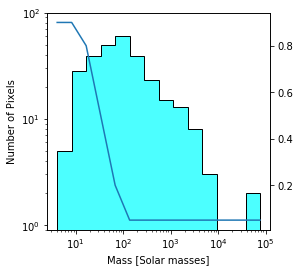

In [147]:
#######################################################################
### IMF missed source detection upper limit:
#######################################################################
plt.close()
catalog = Table.read('/Users/hph/cmzoom_catalog/catalog_acc/catalog_acc.fits')
percent_array=np.array([0.1, 0.1, 0.2, 0.5, 0.8, .95, .95, .95, .95, .95, .95, .95, .95, .95, .95])
missed = np.ones_like(percent_array)-percent_array
num_massive_avg1 = num_massive_avg
num_massive_avg1[num_massive_avg<1]=0
missed_massive = missed*num_massive_avg1

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))

ax.set_ylabel('Number of Pixels')
ax.set_xlabel('Mass [Solar masses]')
massmin = min(catalog['mass'])
massmax = max(catalog['mass'])
massbins = np.logspace(np.log10(massmin), np.log10(massmax),30)
h12,l1,p1 = ax.hist(catalog['mass'],
                   massbins, color='cyan',alpha=0.7, log=True,
                   label='SMA Clumps')
h12,l1,p1 = ax.hist(catalog['mass'],
                   massbins, color='k',alpha=1.0,histtype='step', log=True)
axp = ax.twinx()
#axp.plot(massbins,missed_massive)
#axp.set_yscale('log')
axp.plot(massbins,missed)
#axp.plot(massbins,num_massive_avg)
#axp.set_ylim(0.01,1000)

ax.set_xscale("log")
ax.set_ylim(0.9,100)
plt.show()


In [148]:
num_massive_avg1 = num_massive_avg
num_massive_avg1[num_massive_avg<1]=0

In [149]:
num_massive_avg1

array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.395,   2.939,
         5.837,  11.769,  23.765,  48.069,  97.924, 197.48 , 397.716,
       803.567])

In [150]:
num_missed = np.rint(missed[:-1]*h12)
missed_massive_array = num_missed*num_massive_avg1[:-1]
print(num_missed)
print(num_massive_avg1)
print(missed_massive_array)
print(sum(missed_massive_array))

[ 4. 25. 31. 25. 12.  2.  1.  1.  1.  0.  0.  0.  0.  0.]
[  0.      0.      0.      0.      0.      1.395   2.939   5.837  11.769
  23.765  48.069  97.924 197.48  397.716 803.567]
[ 0.     0.     0.     0.     0.     2.79   2.939  5.837 11.769  0.
  0.     0.     0.     0.   ]
23.335


In [151]:
23/sum(h12*num_massive_avg1[:-1])

0.015412316317019283

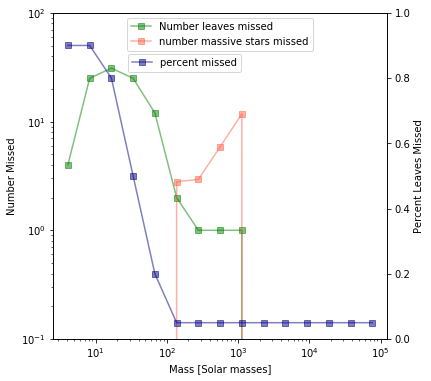

In [152]:
#######################################################################
### IMF missed source detection upper limit:
#######################################################################
plt.close()
catalog = Table.read('/Users/hph/cmzoom_catalog/catalog_acc/catalog_acc.fits')
percent_array=np.array([0.1, 0.1, 0.2, 0.5, 0.8, .95, .95, .95, .95, .95, .95, .95, .95, .95, .95])
#percent_array=np.array([0.1, 0.1, 0.2, 0.5, 0.8, .95, .99, .99, .99, .99, .99, .99, .99, .99, .99])
missed = np.ones_like(percent_array)-percent_array
num_massive_avg1 = np.rint(num_massive_avg)
missed_massive = missed*num_massive_avg1

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6),facecolor='white')
axp = ax.twinx()
ax.plot(massbins[:-1],num_missed,color='green',label='Number leaves missed',marker='s',alpha=0.5)
#ax.plot(massbins,num,color='k',label='number leaves missed')
axp.plot(massbins,missed,color='navy',label='percent missed',marker='s',alpha=0.5)
ax.plot(massbins[:-1],missed_massive_array,color='tomato',label='number massive stars missed',marker='s',alpha=0.5)

ax.set_ylabel('Number Missed')
ax.set_xlabel('Mass [Solar masses]')
ax.legend(loc='upper center')
axp.legend(loc=(0.225,0.82))
axp.set_ylabel('Percent Leaves Missed')
ax.set_xscale("log")
ax.set_yscale('log')
ax.set_ylim(0.1,100)
axp.set_ylim(0.,1)

plt.show()

In [153]:
massbins[:-1]

array([4.07545031e+00, 8.23008143e+00, 1.66200628e+01, 3.35630323e+01,
       6.77781515e+01, 1.36873146e+02, 2.76405562e+02, 5.58181332e+02,
       1.12720742e+03, 2.27631503e+03, 4.59685596e+03, 9.28302297e+03,
       1.87464032e+04, 3.78570251e+04])

In [154]:
s=0
for i,inm in enumerate(missed_massive):
    s+=inm
print (s)

79.55000000000007
